In [1]:
from IPython import get_ipython
%load_ext autoreload
%autoreload 2
import sys
import random
import string
import math
import numpy as np
import fn
import types
import itertools
import json
import copy
import re
import pandas as pd
import torch
import torch.nn as nn
from fn import _
from dataclasses import dataclass
from collections import Counter
from random import sample,choices,choice
from torch.utils.data import Dataset
from itertools import product, chain
from functional import seq
from functional.pipeline import Sequence
from collections import namedtuple 
from collections import defaultdict, OrderedDict
from transformers import AutoModelForCausalLM, LlamaTokenizer
from transformers import Trainer, TrainingArguments, default_data_collator, set_seed, HfArgumentParser

In utils/hub.py: default_cache_path: /home/nrk/.cache/huggingface/hub->/nas/xd/.cache/torch/transformers/


In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [3]:
from common_utils import Timer
with Timer('common_utils'): from common_utils import *
# with Timer('utils'): from utils import *
with Timer('child_utils_nrk_2'): from child_utils_nrk_2 import *
from child_utils_nrk_2 import _str, _cxt2str, _item2str, _s, _be
# from child_frames import *
# with Timer('tasks'): from tasks import *
with Timer('model_utils_nrk_2'): from model_utils_nrk_2 import *
# with Timer('weight_analysis'): from weight_analysis import *

common_utils ... done 0:00:00.000016
child_utils_nrk_2 ... In const.py: Loading tokenizer ... done 0:00:00.090942
done 0:00:00.355446
model_utils_nrk_2 ... done 0:00:00.041575


## 数据部分

In [4]:
# def types_of_things(): return {
#     'animal': ['duck', 'goose', 'dog', 'lion', 'cow', 'donkey', 'horse', 'sheep', 'goat', 'tiger', 'cat', 'pig',
#             'monkey', 'rabbit', 'elephant', 'wolf', 'deer', 'fox', 'gorilla', 'squirrel', 'mouse'], # 'chicken', 'bear', 'zebra', 'giraffe', 'kangaroo', 21-5, 15-8
#     'fruit': ['apple', 'banana', 'pear', 'grapes', 'cherries', 'orange', 'peach', 'plum', 'lemon', 'mango', 'blackberries',
#             'blueberries', 'strawberries', 'durian', 'papaya', 'watermelon', 'pineapple', 'kiwi', 'apricot', 'lime'], # may be food too?
#     # 'vegetable': ['spinach', 'broccoli', 'lettuce', 'cabbage', 'tomato'],
#     'drink': ['tea', 'coffee', 'beer', 'wine', 'whiskey', 'vodka', 'soda', 'juice', 'cocktail'],  # some as alcohol, 21-5, 15-8
#     # 'drink': ['tea', 'coffee', 'beer', 'wine', 'whiskey', 'soda', 'juice',    'vodka', 'cocktail'],  # bad order
#     'food': ['hamburger', 'burger', 'bread', 'meat', 'pizza', 'cake', 'steak', 'spaghetti',
#             # 'biscuits', 'spaghetti', 'chips', 'peanuts', 'nuts', 'pork', 'beef', 'mutton'
#             ],  # last three as meat?~L 21-5?~L 15-8
#     'weapons': ['gun', 'handgun', 'shotgun', 'rifle',  'pistol', 'revolver', 'grenade', 'cannon'], #'bomb', 'dagger', 'sword',], # 21-5, 15-8, though latter prefers firearm
#     # 'color': ['white', 'black', 'red', 'yellow', 'blue', 'green', 'purple', 'pink', 'gray'],  # 15-8
#     'insect': ['mosquito', 'beetle', 'bee'], #'spider', 'ant', 'wasp', 'butterfly'],  # , 'fly'
#     # 'flower': ['rose', 'tulip', 'lily', 'daisy', 'sunflower'],
#     'vehicle': ['car', 'jeep', 'bus', 'taxi', 'motorcycle'],# 'tractor', 'airplane', 'ship', 'bicycle', 'truck', 'train', 'motorbike', 'helicopter', 'carriage',
#                 # 'subway', 'van', 'boat'],  # transportation
#     # 'furniture': ['sofa', 'couch'], #'desk', 'chair', 'table', 'bed', 'bookshelf'],# 'closet', 'wardrobe'],
#     # 'tool': ['hammer', 'spanner', 'awl', 'scissors', 'saw', 'shovel', 'screwdriver', 'wrench', 'drill', 'pliers'], #, 'axe' should be weapon?
#     'clothing': ['shirt', 'T-shirt', 'jeans', 'jacket', 'pants', 'trousers', 'shoes', 'sweater', 'jersey', 'underwear', 'costume', 'uniform'],#'dress', 'coat', 'socks', 'hat', 'tie', 'skirt', ],
#     # 'clothing': ['shirt', 'T-shirt', 'jeans', 'jacket', 'pants', 'trousers', 'shoes', 'sweater', 'underwear', 'costume', 'uniform',   'jersey'],  # bad order
#     # 'appliance': ['microwave', 'fridge', 'washer', 'dryer', 'washing machine'],  #, 'oven'
#     # 'fish': [],
#     # 'plant': ['tree', 'grass', 'bush', 'weed', 'vine'],
#     # 'electronic device': ['laptop', 'iPad', 'phone', 'smartphone'], #'computer', 'television', 'camera', 'printer'],
#     # 'electronic device': ['iPad', 'phone', 'smartphone',    'laptop'],  # bad order
#     'sport': ['football', 'basketball', 'baseball'],# 'volleyball'],  # 'sport or ball?
#     'musical instrument': ['piano', 'violin', 'guitar'],
#     # 'utensil': ['spoon', 'fork', 'knife', 'plate', 'cup', 'bowl', 'pot'],
#     # 'stationery': ['pen', 'pencil', 'paper', 'eraser', 'notebook', 'book', 'ruler', 'ink', 'stapler', 'rubber'],
# }

# names_vocab =  [i for i in string.ascii_uppercase]
# labels = []
# things = []
# for i,j in types_of_things().items():
#     labels.extend([i for _ in range(len(j))])
#     things.extend(j)
# sl_vocab = dict(zip(things,labels))

# boys = [
#     'James', 'David',  'Christopher',  'George',  'Ronald',
#     'John', 'Richard',  'Daniel',  'Kenneth',  'Anthony',
#     'Robert', 'Charles',  'Paul',  'Steven',  'Kevin',
#     'Michael', 'Joseph',  'Mark',  'Edward',  'Jason',
#     'William',  'Thomas',  'Donald',  'Brian',  'Jeff',]
# girls = [
#     'Mary','Jennifer', 'Lisa', 'Sandra', 'Michelle',
#     'Patricia','Maria', 'Nancy', 'Donna', 'Laura',
#     'Linda','Susan', 'Karen', 'Carol', 'Sarah',
#     'Barbara','Margaret', 'Betty', 'Ruth', 'Kimberly',
#     'Elizabeth', 'Dorothy', 'Helen', 'Sharon', 'Deborah',]

# bg = ["boys"]*len(boys)+["girls"]*len(girls)
# name_vocab = dict(zip(boys+girls,bg))

# # all = solid_vocab+toys
# # ft = ["fruits"]*len(solid_vocab)+["toys"]*len(toys)
# # ft_vocab = dict(zip(all,ft))

## 载入模型

In [4]:
models = {}
cache_dir = '/home/xd/.cache/torch/transformers/'  # for models besides t5-3b/11b
# cache_dir = '/mnt/nvme1/xd/.cache/torch/transformers/'  # for gpt-neox-20b on elderberry
proxies = {'http': '192.168.50.1:1081'} 
# curl -x http://192.168.50.1:1081 -L -O [-C -] https://huggingface.co/google/ul2/resolve/main/pytorch_model.bin  # -C for 断点续传
s2s_model_names = ['google/t5-xl-lm-adapt', 'google/t5-xxl-lm-adapt', 'bigscience/T0p', 'bigscience/T0_3B', 
    'allenai/tk-instruct-3b-pos', 'allenai/tk-instruct-3b-def-pos', 'google/ul2']
gpt_model_names = ['EleutherAI/gpt-j-6B/cpu', 'EleutherAI/gpt-j-6B/int8', 'EleutherAI/gpt-j-6B',
                  ]#, 'EleutherAI/gpt-neox-20b/cpu', #'EleutherAI/gpt-neox-20b', 'gpt2-xl', 'gpt2']
llama_model_names = ['lmsys/vicuna-33b-v1.3', 
                    ]
name2device = {'gpt-j-6B': 1, #'models/vicuna/vicuna-7b': 8, 'models/vicuna/vicuna-13b': 8,  
               'vicuna': 1, 'vicuna-7b-v1.3': 1, 'vicuna-13b-v1.3': 1, 'vicuna-33b-v1.3': 1}
# name2device = {'gpt-j-6B': 0, #'models/vicuna/vicuna-7b': 8, 'models/vicuna/vicuna-13b': 8,  
#                'vicuna': 0, 'vicuna-7b-v1.3': 0, 'vicuna-13b-v1.3': 0, 'vicuna-33b-v1.3': 0}
for model_name in llama_model_names[-1:]+ gpt_model_names[:0]:
    if model_name in models: continue
    with Timer(model_name):
        model_cls = AutoModelForCausalLM #if any(s in model_name for s in ['gpt', 'fairseq-dense']) else T5ForConditionalGeneration
        _cache_dir = cache_dir# .replace('/nas/', '/nas2/') if 'gpt' not in model_name else cache_dir
        dst = model_name.split('@')[-1] if '@' in model_name else 'cuda'
        model_name = model_name.replace('/cpu', '').replace('/int8', '')
        _model_name = model_name.split('/')[-1]
        if _model_name.startswith('vicuna'): _model_name = 'vicuna'
        kwargs = dict(cache_dir=_cache_dir, proxies=proxies, low_cpu_mem_usage=True)
        if dst == 'cpu':
            model = model_cls.from_pretrained(model_name, **kwargs)
        else:  # fp16 or int8 on GPU
            device = name2device[_model_name]
            device_map = get_device_map(devices=device, **name2mapping[_model_name]) if isinstance(device, Iterable) else None
            dtype_kwargs = dict(load_in_8bit=True) if dst == 'int8' else dict(torch_dtype=torch.float16)
            revision_kwargs = dict(revision='float16') if _model_name == 'gpt-j-6B' else {}
            model = model_cls.from_pretrained(model_name, device_map=device_map, **dtype_kwargs, **revision_kwargs, **kwargs)
            if device_map is None: model = model.to(device)
        if hasattr(model.config, 'use_cache'): model.config.use_cache = False  # save GPU mem
        # to avoid slow loading of AutoTokenizer->TokenizerFast
        tokenizer_cls = LlamaTokenizer 
        tokenizer = tokenizer_cls.from_pretrained(model_name, cache_dir=_cache_dir)
        unify(model); unify_tokenizer(tokenizer)
        models[model_name] = model, tokenizer

lmsys/vicuna-33b-v1.3 ... In huggingface_hub.file_download.cached_download: url = https://huggingface.co/lmsys/vicuna-33b-v1.3/resolve/main/config.json
/home/xd/.cache/torch/transformers/vicuna-33b-v1.3-config.json -> /home/xd/.cache/torch/transformers/fe10cc433491a8058e42e13996d5a2c8d7d8eb336d4c10686b80e1118839e1fa.f4f76b6689b6a63600ca3396ba861970f33ce58d299ff2d8ed9a88b8707d0db8 not exist!
In huggingface_hub.file_download.cached_download: url = https://huggingface.co/lmsys/vicuna-33b-v1.3/resolve/main/pytorch_model.bin.index.json


In huggingface_hub.file_download.cached_download: url = https://huggingface.co/lmsys/vicuna-33b-v1.3/resolve/main/pytorch_model-00001-of-00007.bin
/home/xd/.cache/torch/transformers/vicuna-33b-v1.3-pytorch_model-00001-of-00007.bin -> /home/xd/.cache/torch/transformers/128272c39b1758216e9805d4c2b06364b7c6be3a11f3fc1b4a9a2768ce162ffc.dfd680ccc93f8b148a8bf33ed51ff6fac6cb71923b73b31524618794f53ba454 not exist!
In huggingface_hub.file_download.cached_download: url = https://huggingface.co/lmsys/vicuna-33b-v1.3/resolve/main/pytorch_model-00002-of-00007.bin
/home/xd/.cache/torch/transformers/vicuna-33b-v1.3-pytorch_model-00002-of-00007.bin -> /home/xd/.cache/torch/transformers/c64b09a11187fcf762bf950545b89c014062653c7cb0522b025bfd6422ef0a05.2b40a8e63ebb8cd2bf4dcdc5b03620936b95e6384786882858b44e0c24ecaa23 not exist!
In huggingface_hub.file_download.cached_download: url = https://huggingface.co/lmsys/vicuna-33b-v1.3/resolve/main/pytorch_model-00003-of-00007.bin
/home/xd/.cache/torch/transformer

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In huggingface_hub.file_download.cached_download: url = https://huggingface.co/lmsys/vicuna-33b-v1.3/resolve/main/generation_config.json
In huggingface_hub.file_download.cached_download: url = https://huggingface.co/lmsys/vicuna-33b-v1.3/resolve/main/tokenizer.model
In huggingface_hub.file_download.cached_download: url = https://huggingface.co/lmsys/vicuna-33b-v1.3/resolve/main/special_tokens_map.json
In huggingface_hub.file_download.cached_download: url = https://huggingface.co/lmsys/vicuna-33b-v1.3/resolve/main/tokenizer_config.json
done 0:01:32.018419


In [5]:
tokenizer

LlamaTokenizer(name_or_path='lmsys/vicuna-33b-v1.3', vocab_size=32000, model_max_length=2048, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'eos_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'unk_token': AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'pad_token': '<unk>'}, clean_up_tokenization_spaces=False)

In [6]:
model_name = llama_model_names[-1]  # gpt_model_names/llama_model_names/engines
assert not model_name.endswith('/int8'), model_name
model, tokenizer = models[model_name]
model_name_gpu = model_name.replace('/cpu', '/int8') if model_name.endswith('/cpu') else model_name# + '/int8'
model_gpu = models[model_name_gpu][0] if model_name_gpu in models else model  # for prediction rather than attribution

blocks = model.transformer.h
for i, b in enumerate(blocks): b.layer = i
ln_f = model.transformer.ln_f
L, H, embed_dim = len(blocks), blocks[0].attn.num_heads, blocks[0].attn.embed_dim

## 判断逻辑部分

In [8]:
nums=["Zero","One","Two","Three","Four","Five","Six"]
def Compare_the_quantity_of_mask1_and_mask2(cxt, query, g2c=False):
    s = cxt
    q = query
    if(seq(s).filter(lambda x: sl_vocab[x] == q[0]).len() > len(s)/2):
        return ">"
    elif(seq(s).filter(lambda x: sl_vocab[x] == q[0]).len() < len(s)/2):
        return "<"
    else:
        return "="
    
def How_many_mask1_are_there(cxt, query, g2c=False):
    s = cxt
    q = query
    return nums[seq(s).filter(lambda x: sl_vocab[x] == q[0]).len()]

def Are_there_more_mask1_than_mask2(cxt, query, g2c=False):
    s = cxt
    q = query
    return (seq(s).filter(lambda x: sl_vocab[x] == q[0]).len() >= len(s)/2)

def Do_mask1_and_mask2_have_the_same_thing(cxt, query, g2c=False):
    SC= cxt
    s,d = query
    return (seq(SC).filter(_[0] == s).map(_[1])
                 .intersection(
                     seq(SC).filter(_[0] == d).map(_[1]))
                 .non_empty())#,SC,(s,d)

def Does_mask2_have_all_the_things_that_mask1_has(cxt, query, g2c=False):
    SC= cxt
    s,d = query
    return (seq(SC).filter(_[0] == d).map(_[1])
                 .union(
                     seq(SC).filter(_[0] == s).map(_[1]))
                 ).distinct().len()== seq(SC).filter(_[0] == d).map(_[1]).distinct().len()


def Do_all_mask1_have_mask2(cxt, query, g2c=False):
    SC, CD, NS, key, bg = cxt  # SC paris: studeng-course relation, CD pairs: course-department function
    d, ss = query  # ss: 种类，d: 男/女
#     print("SC:",SC,"\nCD:",CD,"\nNS:",NS,"\nbg",bg,"\nkey",key)
#     return seq(ss).map(lambda s: seq(SC).filter(_[0] == s).map(_[1]).intersection(CD.filter(_.[1] == d).map(_.[0])).non_empty()).all()
    name = [i[0] for i in NS if i[1] == d]
    
    return (seq(name)
            .map(lambda s: seq(SC).filter(_[0] == s).map(_[1])  # 找到所有该性别的人
                 .difference(
                     seq(ss)) #  那一类的物品
                 .empty())  # s选了d系的课程
            .all())  # 学生子集ss都选了d系的课程

# CD  #所选物品，物品种类  S
# SC  #人，物品  
# NS  #人，性别    

def Is_mask1_a_mask2(cxt, query, g2c=False): #新建联系，把vocab和属性连起来形成新集合
    NA = cxt
    s,d = query
    d=d+'s'
    return (seq(NA).filter(_[0] == s).map(_[1]).select(lambda x: name_vocab[x] == d).all())

def Is_the_gender_of_mask1_the_same_as_mask2(cxt, query, g2c=False):
    NA = cxt
    
    s,d = query
    d = seq(NA).filter(_[0] == d).map(_[1])
    return (seq(NA).filter(_[0] == s).map(_[1]).select(lambda x: name_vocab[x] == name_vocab[d[0]]).all())

In [9]:
bg = ["boy","girl"]

## 生成逻辑部分

In [10]:
def Compare_sample(vocab, k):
    all_vocab,s_vocab,l_vocab = vocab
    k_cxt,k_query = k  # k_cxt = 5 ,k_query =2
    Vocab = s_vocab+l_vocab
    while seq(s:=sample(Vocab, k_cxt)).map(lambda x: sl_vocab[x]).distinct().len() <= 1:continue
    return s

def compare_sample(vocab, k):
    all_vocab,s_vocab,l_vocab = vocab
    k_cxt,k_query = k  # k_cxt = 5 ,k_query =2
    N = list(all_vocab.keys())
    s = sample(N, k_cxt) 
    return s

def Compare_query(cxt,vocab,k): 
    NA = cxt
    all_vocab,s_vocab,l_vocab = vocab
    k_cxt,k_query = k
    q = [all_vocab[s_vocab[0]]]+[all_vocab[l_vocab[0]]]
    return q

def count_sample(vocab, k):
    all_vocab = vocab
    k_cxt,k_query = k  # k_cxt = 4 ,k_query =1
    N = list(all_vocab.keys())
    s = sample(N, k_cxt) 
    return s

def count_query(cxt,vocab,k): 
    NA = cxt
    k_cxt,k_query = k
    N = list(vocab.values())
    q = sample(N,k_query)
    return q


def compare_query(cxt,vocab,k): 
    NA = cxt
    all_vocab,s_vocab,l_vocab = vocab
    k_cxt,k_query = k
    q = sample(s_vocab,1)+sample(l_vocab,1)
    random.shuffle(q)
    return q

def intersection_sample(vocab, k):
    S_vocab, C_vocab = vocab  
    k_S, k_C, k_SC = k  # k_S = 3, k_C = 6, , k_SC = 3
    S, C= sample(sorted(S_vocab), k_S), sample(C_vocab, k_C)
    while(torch.tensor([C[i] == C[0] for i in range(k_C)]).sum() == k_C):
        C = sample(C_vocab, k_C)
    all_SC = list(itertools.product(S, C)) 
#     print(type(seq(SC := sample(all_SC, k_SC))))
    while seq(SC := sample(all_SC, k_SC)).map(_[0]).distinct().len() < k_S: continue 
    return SC

def intersection_query(cxt,vocab,k):
    SC= cxt
    k_S, k_C, k_SC = k #k_s = 3, k_C = 5 , k_sc = 6
    S = select_distinct(SC, 0)
    s,d = sample(S,2)
    return s, d


def complement_query(cxt,vocab,k):
    SC= cxt
    k_S, k_C, k_SC = k #k_s = 3, k_C = 5 , k_sc = 6
    S = select_distinct(SC, 0)
    s,d = sample(S,2)
    return s, d

def complement_sample(vocab, k):
    S_vocab, C_vocab = vocab  
    k_S, k_C, k_SC = k  # k_S = 3, k_C = 4, k_SC = 5
    S, C= sample(sorted(S_vocab), k_S), sample(C_vocab, k_C)

    all_SC = list(itertools.product(S, C))  
    while seq(SC := sample(all_SC, k_SC)).map(_[0]).distinct().len() < k_S: continue 
    return SC

def all_a_sample(vocab, k):
    all_vocab, name_vocab, value, bg = vocab  # 物品，所选物品，所选种类，男女
    k_N, k_S = k
    name, S,  bg = sample(sorted(name_vocab),k_N), choices(value, k=k_S),  sample(bg, 1)[0]
    key = sample(S, 1)[0]
#     CD = list(zip(S,[all_vocab[i] for i in S]))  #所选物品，物品种类
    SC = list(zip(sample(name,k_N),S))           #人，物品
    NS = [(i[0],name_vocab[i[0]]) for i in SC]         #人，性别
    return SC, S, NS, key, bg

def all_a_query(cxt,vocab,k):
    SC, S, NS, key, bg = cxt
    return bg, key

def all_a_query2str(query):
    d, ss = query
#     query_str = '%s,%s?' % (', '.join(ss[:-1]) + ' and ' + ss[-1], d)
    return '. ' + query_str

def find_sample(vocab, k): 
    name_vocab, all_vocab = vocab
    k_name, k_all = k  
#     vocab = sample(list(types_of_things().keys()),2)
#     S = types_of_things()[vocab[0]]+types_of_things()[vocab[1]]
#     N, A = sample(name_vocab, k_name), sample(S, k_all)
    while(1):
        N, A = sample(name_vocab, k_name), sample(sorted(all_vocab), k_all)
        D = [all_vocab[i] for i in A]
        NA = list(map(lambda x, y: (x,y),N, A))
        if(seq(N).intersection(seq(A).map(_[0])).len() == 0):
            break
    return NA

def find_sample0(vocab, k): 
    name_vocab, all_vocab = vocab
    k_name, k_all = k  
#     vocab = sample(list(types_of_things().keys()),2)
#     S = types_of_things()[vocab[0]]+types_of_things()[vocab[1]]
#     N, A = sample(name_vocab, k_name), sample(S, k_all)
    N, A = sample(name_vocab, k_name), sample(sorted(all_vocab), k_all)
    D = [all_vocab[i] for i in A]
    NA = list(map(lambda x, y: (x,y),N, A))
    return NA

def find_query(cxt,vocab,k): 
    NA = cxt
    k_name, k_all = k
    S = select_distinct(NA, 0)
    s = sample(S,1)
    d = sample(["boy","girl"],1)
    return s[0],d[0]

def find_query0(cxt,vocab,k): 
    NA = cxt
    k_name, k_all = k
    S = select_distinct(NA, 0)
    s = sample(S,2)
    return s[0],s[1]

def query2str(query,flag=0,g2c=False):
    if(flag != 0 and g2c==False):
        return query+"?"
    else:
        return query+"."


def make_input_str(task, nrows=4, ncols=4, flag = 0, full_vocab=None, g2c=False, ans_vocab=[True, False]):
    if full_vocab is None: full_vocab = string.ascii_uppercase + string.digits
    transform_fn, vocab_fn, sample_fn, query_fn, query2str = task
    instruction = transform_fn.__name__.replace('_', ' ')
    if vocab_fn is None: vocab_fn = lambda: full_vocab
    if query_fn is None: query_fn = lambda *_: None
    examples = []
    query = None
    Ans = []

    while(1):
        vocab = vocab_fn()
        l = sample_fn(vocab, k=ncols)
        query = query_fn(l, vocab, ncols)
        ans = transform_fn(l, query=query,g2c=g2c)
        if len(Ans)==0:
            Ans.append(ans)
            
        else:
            if ans==Ans[-1]:
                continue
            else:
                Ans.append(ans)

        examples.append([instruction, l, query, ans])
        if len(Ans)==nrows:
            break      
    random.shuffle(examples)
    
#     examples = balance(examples,ans_vocab)
#     desc = promptize(instruction) if True else ''
    text = '\n'.join([make_example_str(e, query2str, flag, g2c) for e in examples])
#     text = desc + '\n' + text + '\n'
    return text,examples

def make_example_str(example, query2str, flag=0, g2c=False):
    instruction, cxt, query, ans = example
    if type(ans) not in [Sequence, list]: ans = [ans]
    ans = [verbalize(a) for a in ans]
    query_text = instruction
    if g2c==True: 
        instruction = 'mask1 is a mask2'
#         if ans=='No':
#             query[1] = ''
    try:
        query_text = instruction.replace('mask1',query[0])
        query_text = query_text.replace('mask2',query[1]) if ans==['Yes'] else query_text.replace('mask2',bg[abs(1-bg.index(query[1]))])
    except:
        pass
    
#     return '%s -> %s' % (''.join(l[0]) + make_query_str(instruction if with_instruction else None, query), ' '.join(ans))  # by nrk
#     return '%s -> %s' % (' '.join(l) + make_query_str(instruction if with_instruction else None, query), ' '.join(ans))  # by XD
#     return '%s -> %s' % (make_context_str(cxt) + make_query_str(instruction if with_instruction else None, query[0]), ' '.join(ans))  
#     return '%s Answer: %s' % (make_context_str(cxt, flag)+". " + query2str(query_text,flag), ' '.join(ans)+'.')
    if g2c==True:
        return '%s' % (make_context_str(cxt, flag)+". " + query2str(query_text,flag,g2c=g2c))
    else:
        return '%s %s' % (make_context_str(cxt, flag)+". " + query2str(query_text,flag,g2c=g2c), ' '.join(ans)+'.')

def promptize(s):
#     return prompt_token * len(s.split())
    return s

def verbalize(obj):
    if type(obj) == bool: return 'Yes' if obj else 'No'
    return str(obj)

def make_context_str(cxt, flag=0):
    if type(cxt) == list:
        if flag == 1:
            return is2str(cxt) if type(cxt[0]) == tuple and len(cxt[0]) == 2 else list2str(cxt)
            
        else:
            return has2str(cxt) if type(cxt[0]) == tuple and len(cxt[0]) == 2 else list2str(cxt)
    if type(cxt) == tuple:
        return make_context_str(cxt[0],flag)  # 用分号分隔context的不同部分
    
def list2str(l): return 'There are '+','.join(str(i) for i in l)
def has2str(pairs): return ', '.join(str(k) + ' has ' + str(v) for k, v in pairs)
def is2str(pairs): return ', '.join(str(k) + '\'s name is ' + str(v) for k, v in pairs)
def select_distinct(tuples, col): return seq(tuples).map(_[col]).distinct().list()

In [11]:
tasks = [
    (Compare_the_quantity_of_mask1_and_mask2,  lambda: [sl_vocab,(choose:=random.sample(list(types_of_things().values()),2))[0],choose[1]],  Compare_sample,  Compare_query, query2str),
    (How_many_mask1_are_there,   lambda: sl_vocab,                            count_sample,       count_query, query2str),
    (Are_there_more_mask1_than_mask2,              lambda: [sl_vocab,(choose:=random.sample(list(types_of_things().values()),2))[0],choose[1]],          Compare_sample,  Compare_query, query2str),
    
    (Do_mask1_and_mask2_have_the_same_thing,           lambda: [name_vocab,types_of_things()['food']],     intersection_sample,    intersection_query, query2str),
    (Does_mask2_have_all_the_things_that_mask1_has,           lambda: [name_vocab,types_of_things()['vehicle']],     complement_sample,    complement_query, query2str),
    
    (Do_all_mask1_have_mask2,    lambda: [sl_vocab,name_vocab,values:=sample(types_of_things()[[list(types_of_things().keys())[random.randint(0,9)]][0]],2),["boys","girls"]],     all_a_sample,    all_a_query, query2str),
    (Is_the_gender_of_mask1_the_same_as_mask2, lambda: [string.ascii_uppercase,name_vocab],  find_sample0,    find_query0, query2str),
    (Is_mask1_a_mask2,            lambda: [[i for i in string.ascii_uppercase if i not in['A','S','N','I']],name_vocab],      find_sample,    find_query, query2str),
    
]
key = ['Compare_the_quantity_of_mask1_and_mask2','How_many_mask1_are_there','Are_there_more_mask1_than_mask2',
       'Do_mask1_and_mask2_have_the_same_thing','Is_mask1_a_subset_of_mask2','Do_all_mask1_have_mask2',
       'Is_the_gender_of_mask1_the_same_as_mask2','Is_mask1_a_mask2']

In [12]:
n_total = 12;  nrows = 8
batch_size = 12;  k_shot = 2; g2c=True
seed(42)
######input_strs = [make_input_str(tasks[num:=0], nrows=9, ncols=(4,2)) for __ in range(n_total)];   #Compare the values of two sets.
# input_strs = [make_input_str(tasks[num:=1], nrows=nrows, ncols=(3,1), ans_vocab=[0,1,2,3], flag = 2) for __ in range(n_total)];    #How_many_elements_are_similar_to_the_example
# input_strs = [make_input_str(tasks[num:=2], nrows=nrows, ncols=(3,2), flag = 2) for __ in range(n_total)] ;#Is_the_number_of_first_elements_greater_than_the_second_one

# input_strs = [make_input_str(tasks[num:=3], nrows=nrows, ncols=(3,6,3), flag = 2) for __ in range(n_total)];     #Is the intersection of two sets empty.
# input_strs = [make_input_str(tasks[num:=4], nrows=nrows, ncols=(2,5,3), flag = 2) for __ in range(n_total)];    #Is the first set a subset of the second one
# input_strs = [make_input_str(tasks[num:=5], nrows=nrows, ncols=(5, 5), flag = 2) for __ in range(n_total)];    #Do_all_students_choose_courses_in_a_department
# input_strs = [make_input_str(tasks[num:=6], nrows=nrows, ncols=(3,3), flag = 1) for __ in range(n_total)];    #Are_there_elements_belonging_to_the_same_class

input_strs = [make_input_str(tasks[num:=7], nrows=nrows, ncols=(3,3), flag = 1, g2c=g2c) for __ in range(n_total)]; 

text= copy.deepcopy(input_strs)
for i in range(len(input_strs)):
    text[i] = "\n ".join([line[:1].upper() + line[1:] for line in input_strs[i][0].split("\n")])+"\n"

print(text)
# # # 保存成 JSON 
# with open(f"nrk/data/data_{num}.txt", "wb") as f:
#     pickle.dump(input_strs, f)
    
# print(input_strs)
# eval_dataset = CHILDDataset(text, tokenizer)

["J's name is Sharon, T's name is Maria, Y's name is Linda. Y is a girl.\n Z's name is Michael, T's name is David, H's name is Steven. Z is a boy.\n Q's name is Richard, V's name is Sandra, X's name is Ronald. Q is a boy.\n T's name is Ronald, P's name is Deborah, Z's name is Maria. Z is a girl.\n X's name is Donald, F's name is Donna, J's name is Kimberly. J is a girl.\n K's name is Nancy, D's name is Sharon, H's name is Jennifer. K is a girl.\n Y's name is Susan, E's name is James, B's name is George. E is a boy.\n Q's name is Sarah, J's name is Mary, G's name is Lisa. G is a girl.\n", "F's name is Christopher, D's name is Mark, L's name is William. L is a boy.\n K's name is Charles, E's name is Donna, F's name is Laura. F is a girl.\n F's name is Mark, H's name is Kevin, X's name is Betty. X is a girl.\n Z's name is Kevin, O's name is Susan, D's name is Betty. D is a girl.\n T's name is Lisa, F's name is James, U's name is Dorothy. U is a girl.\n M's name is Nancy, Q's name is Eliza

In [13]:
# n_total = 12;  nrows = 8
# batch_size = 12;  k_shot = 6
# num = 7
# with open(f'nrk/data/data_{num}.txt',"rb") as f:
#     input_strs = pickle.load(f)

# text= copy.deepcopy(input_strs)
# for i in range(len(input_strs)):
#     text[i] = "\n ".join([line[:1].upper() + line[1:] for line in input_strs[i][0].split("\n")])+"\n"

# 需加入g2c功能：需要大幅修改

In [13]:
def find_ans0(query,cxt):
    if isinstance(query, tuple):
        ans0 = tuple([i[1] for i in cxt if i[0] in query])
    else:
        ans0 = [i[1] for i in cxt if i[1] in types_of_things()[query[0]]]
        ans0 = tuple(ans0) if len(ans0) != 0 else ()
        
    return ans0

def find_ans(text):
    a = text.split("\n")
    return a
    
def make_example_ml(input_str,nrows,g2c=False):
    Example = []
    
    for i in range(len(input_str)):
        example = []
        for j in range(nrows):
            cxt = input_str[i][1][j][1]
            query = input_str[i][1][j][2]
            candidates,ans_chain =  [[]],[]
            if input_str[i][1][j][3] in [True,False] and g2c==False:
                ans = 'Yes' if input_str[i][1][j][3]==True else 'No'
            elif g2c == True:
                ans = input_str[i][1][j][2][1] if input_str[i][1][j][3]==True else bg[1-abs(bg.index(input_str[i][1][j][2][1]))]
            else:
                ans = input_str[i][1][j][3]
                
            if not isinstance(cxt[0], tuple):
                cxt = [(None,cxt[i]) for i in range(len(cxt))]
            
            
            candidates.append([cxt[i][0] for i in range(len(cxt))])
            candidates.append([cxt[i][1] for i in range(len(cxt))])
            candidates.append([cxt[i][1] for i in range(len(cxt))])
            candidates.append(['boy','girl'])
            
            
            ans0 = find_ans0(query,cxt)
            ans_chain.append([cxt[i][0] for i in range(len(cxt)) if cxt[i][1] in ans0])
            ans_chain.append(ans0)
            ans_chain.append(query[1])
            
#             print("cxt:",cxt)
#             print("query:",query)
#             print("candidates:",candidates)
#             print("ans_chain:",ans_chain)
            example.append([cxt,query[0],tuple(candidates),tuple(ans_chain),ans])
        Example.append(example)    
    return Example

J's name is Sharon, T's name is Maria, Y's name is Linda. Y is a girl.
 Z's name is Michael, T's name is David, H's name is Steven. Z is a boy.
 Q's name is Richard, V's name is Sandra, X's name is Ronald. Q is a boy.
0.19180133550738296 0.9305555555555556 0.888861111111111


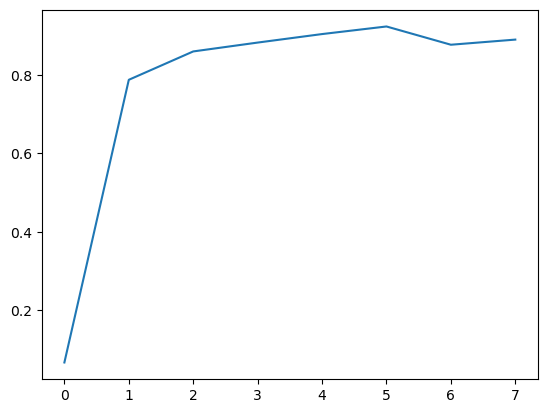

attribute_tree ... In attribute_tree: attribute_step  ... done 0:00:03.072061
In _add_node: add @7 38-m 45
In _add_node: add @8 57-m 38
In _add_node: add @9 31-m 38
In _add_node: add @10 51-m 35
In _add_node: add @12 55-m 32
In _add_node: add @14 49-m 26
In _add_node: add @0 34-7 100 B->A]^ 26/10 attn
In _add_node: add @1 31-50 93 B->A]^ 64/52 attn
In _add_node: add @2 37-47 76 B->A]^ 60/42 attn
In _add_node: add @3 45-36 61 B->A]^ 43/34 attn
In _add_node: add @4 40-21 60 B->A]^ 47/21 attn
In _add_node: add @5 43-36 58 B->A]^ 63/22 attn
In _add_node: add @6 28-34 45 B->A]^ 50/42 attn
In _add_node: add @11 58-13 35 B->A]^ 49/21 attn
In _add_node: add @13 32-12 27 B->A]^ 52/23 attn
In _add_node: add @[7,8,9,10,12,14] 38-m,57-m,31-m,51-m,55-m,49-m 26 B->B 41
In _add_node: add @[0,1,2,3,4,5,6,11,13] 34-7,31-50,37-47,45-36,40-21,43-36,28-34,58-13,32-12 27 B->A]^ 30
In _add_node: add 34-7 B->A]^ attn
In attribute_tree: attribute_step 34-7 B->A]^ attn ... done 0:00:02.120450
In _add_node: add

In attribute_tree: attribute_step 17-18 B->Q] ... done 0:00:01.161544
In _add_node: add @1 15-40 86 Q]->Q] 2/6/-27
In _add_node: add @2 15-22 58 Q]->Q] 2/4/-33
In _add_node: add @9 12-m 33
In _add_node: add @13 8-1 29 Q]->Q] 1/3/-281
In _add_node: add @0 16-17 100 Q]->A]^ 15/27/100 attn
In _add_node: add @0 16-17 100 Q]->A]^ 15/27/100
In _add_node: add @3 15-7 55 Q]->A]^ 5/7/100 attn
In _add_node: add @3 15-7 55 Q]->A]^ 5/7/100
In _add_node: add @4 11-1 47 Q]->A]^ 4/4/100 attn
In _add_node: add @4 11-1 47 Q]->A]^ 4/4/100
In _add_node: add @5 13-46 43 Q]->A]^ 1/2/100 attn
In _add_node: add @5 13-46 43 Q]->A]^ 1/2/100
In _add_node: add @7 12-18 39 Q]->A]^ 7/13/100 attn
In _add_node: add @7 12-18 39 Q]->A]^ 7/13/100
In _add_node: add @8 8-34 34 Q]->A]^ 2/2/100 attn
In _add_node: add @8 8-34 34 Q]->A]^ 2/2/100
In _add_node: add @10 14-16 33 Q]->A]^ 3/4/100 attn
In _add_node: add @10 14-16 33 Q]->A]^ 3/4/100
In _add_node: add @11 14-27 33 Q]->A]^ 1/1/100 attn
In _add_node: add @11 14-27 33 

In [15]:
# result = {}
# save_results = False 
# rel1_kwargs = {'x_f': None} 
# for i in range(0,n_total,batch_size):
#     mathlogic_dataset = []
#     all_examples = make_example_ml(input_strs[i:i+batch_size],nrows,g2c)
#     mathlogic_dataset.append(tuple(all_examples))
#     mathlogic_dataset.append(tuple(text[i:i+batch_size]))
#     mathlogic_dataset.append(tuple([tuple(['a' for _ in range(nrows)]) for _ in range(batch_size)]))
# #     print(mathlogic_dataset)
#     r = None
#     r = generate_and_predict_batch(model, tokenizer, task= None, nrows = nrows, k_shot = k_shot, batch_size = batch_size,
#                                    mathlogic_dataset = mathlogic_dataset, result=r, verbose=False)
#     if True or r.root is None:
#         r.root = node = add_node(None, layer=L, label_type='labels')
# #         ap = 'query1->query0+' 
# #         node = add_node(r.root, layer=9, head=36, attn_pattern=ap,label_type= None,H=H,step=2,force=True)
# #         node.data.top_score = node.data.ap_score = 0.
#     _ = attribute_tree_on(r.data_tuples, model, node, 8, filter_fn_nrk, topk=15, threshold_score=0, k_shot=k_shot, mix=True, device=None, verbose=True )

In [16]:
print_tree(r.root) 

 ┌@[7,8,9,10,12,14] 38-m,57-m,31-m,51-m,55-m,49-m 26 B->B 41
 ├@[0,1,2,3,4,5,6,11,13] 34-7,31-50,37-47,45-36,40-21,43-36,28-34,58-13,32-12 27 B->A]^ 30
 ├@7 38-m 45
 ├@8 57-m 38
 ├@9 31-m 38
 ├@10 51-m 35
 ├@12 55-m 32
 ├@14 49-m 26
 ├@0 34-7 100 B->A]^ 26/10 attn
 ├@1 31-50 93 B->A]^ 64/52 attn
 ├@2 37-47 76 B->A]^ 60/42 attn
 ├@3 45-36 61 B->A]^ 43/34 attn
 ├@4 40-21 60 B->A]^ 47/21 attn
 ├@5 43-36 58 B->A]^ 63/22 attn
 ├@6 28-34 45 B->A]^ 50/42 attn
 ├@11 58-13 35 B->A]^ 49/21 attn
 ├@13 32-12 27 B->A]^ 52/23 attn
 ┤
 │                ┌@[0,2,3,4,6,7,9,10,11,12,13] 26-51,26-13,23-27,10-13,11-1,26-27,24-34,13-29,16-17,15-4 27,20-45 26 B->A]^ 35
 │                ├@[5,8,14] 24-51,32-47,18-13 26 B->Q+ 10
 │                ├@[1] 27-m B->B 10
 │                ├@0 26-51 100 B->A]^ 36/23 attn
 │                ├@2 26-13 77 B->A]^ 61/51 attn
 │                ├@3 23-27 68 B->A]^ 54/30 attn
 │                ├@4 10-13 59 B->A]^ 22/18 attn
 │                ├@6 11-1 49 B->A]^ 71/39 attn
 │   

In [12]:
#修改filter_fn, 满足条件才可以往后归
# def filter_fn_nrk(p, c):
#     if c.layer == 0: return False
# #     if p.label_type and 'attn_labels' in p.label_type and '->~<s>' in p.label_type: return False
#     pap, ap = abbreviate_attn_pattern(p.attn_pattern or ''), abbreviate_attn_pattern(c.attn_pattern)
#     return (p.step == -1  and c.top_score > 0.4 and c.head != c.H or
#             p.step == 0 and c.top_score > 0.5 and c.head != c.H or# and c.top_score > 0.3 and c.ap_score > 0.4 and ap == 'B->A]^' and c.head != c.H or
#             p.step == 1 and c.top_score > 0.4 and c.head != c.H and ap == 'B->Q1' or
#             p.step == 2 and c.top_score > 0.5 and c.ap_score > 0.1 and c.head != c.H and p.label_type != 'attn_labels' and c.label_type != 'attn_labels' and ap not in ['Q1->A]^','Q1->Q1]^'] or
#             p.step == 3 and c.top_score > 0.5 and c.ap_score > 0.3 and c.head != c.H and c.label_type != 'attn_labels' or ap == 'B->Q1' or
#             p.step == 4 and c.top_score > 0.4 and c.ap_score > 0.1 and c.head != c.H and c.label_type != 'attn_labels'or (ap in ['Q1+->Q1'] and c.top_score > 0.4 and c.ap_score > 0)
            
# #             p.step == 3 and ap in ['Q1->Q1-','Q1->Q0-'] 
# #             p.step == 4 and ap in ['Q1-->Q0-'] or 
# #             p.step == 5 and ap == 'Q0-->Q1+^'

#     )
def filter_fn_nrk(p, c):
    if c.layer == 0: return False

#     if p.label_type and 'attn_labels' in p.label_type and '->~<s>' in p.label_type: return False
    pap, ap = abbreviate_attn_pattern(p.attn_pattern or ''), abbreviate_attn_pattern(c.attn_pattern)
    return (
            p.step == -1 and c.top_score>0.4
            
#             p.step == -1 and c.top_score>0.5 and ap == 'B->B' or  #< Ruth has a Violin. Carol has a Beetle. Ronald has Blueberries. >. Ruth has a kind of musical instrument
#             p.step == 0 and (c.layer,c.head) in [(28,8),(18,18),(19,24)] or
#             p.step == 1 and c.top_score>0.5 and c.label_type == None or
#             p.step == 2 and c.top_score>0.5
        
#             p.step == -1 and c.top_score>0.6 or  # Is elephant a kind of Animals?Yes
#             p.step == 0 and (c.layer,c.head) in [(20,52),(24,52)] or
#             p.step == 1 and (c.layer,c.head) in [(18,22),(15,50)] and c.label_type == None or
#             p.step == 2 and (c.layer,c.head) in [(14,52)] or
#             p.step == 3 and c.top_score>0.7
        
        
#             p.step == -1 and (c.layer,c.head) == (34,7) or   
#             p.step == 0 and (c.layer,c.head) in [(27,52),(26,51),(24,51)] or
#             p.step == 1 and (c.layer,c.head) in [(24,35),(22,52),(15,0)] or
#             p.step == 2 and (c.layer,c.head) in [(12,8),(17,18)]
        
#             p.step == -1 and (c.layer,c.head) in [(43,52),(36,52)] or
#             p.step == 0 and (c.layer,c.head) in [(28,52),(38,52),(34,52),(24,52)] or
#             p.step == 1 and (c.layer,c.head) in [(22,52),(33,52)] or
#             p.step == 2 and (c.layer,c.head) in [(18,22),(17,10)] and c.label_type == None
        
        
#             p.step == -1 and c.top_score>0.5 or
#             p.step == 0 and c.top_score>0.5 or
#             p.step == 1 and ap in ['B->Q+','B->R]']
        
         
#             p.step == -1  and (c.layer,c.head) in [(45,52),(36,52)] or # attribute q of (31-50，26-13)
#             p.step == 0  and ((c.layer,c.head) in [(31,50),(26,13)] and c.label_type != None) or
#             p.step == 1 and (c.layer,c.head) == (22,52) and c.label_type == None or
#             p.step == 2 and c.top_score>0.4 and c.ap_score>0.3 and c.head != c.H or
#             p.step == 3 and (c.layer,c.head) == (14,7)
        
        
#             p.step == -1  and (c.layer,c.head) in [(45,52),(36,52)] or # attribute v of g2c
#             p.step == 0  and ((c.layer,c.head) in [(20,52),(27,52)] or ((c.layer,c.head) in [(30,46),(26,49)] and c.label_type != None)) or
#             p.step == 1 and (c.layer,c.head) in [(11,17),(18,22),(26,51),(24,34)] and c.label_type == None or
#             p.step == 2 and c.top_score>0.5 and c.ap_score > 0.2 and c.label_type == None
#             
           )

In [1]:
# # #老师的样例
tasks0 = [
#     (lambda: [TreeSet(types_of_things).use(['equal', 'child', 'sibling']), TreeSet(types_of_things).use(['equal', 'child', 'sibling'])], MlM_gen, None, None,
#     ),
#     (lambda: [TreeSet(types_of_things).use(['equal']), TreeSet(types_of_things).use(['child'])], MlM_gen,
#      lambda *args, **kwargs: '', lambda q, _: f"{q} is",
#     ),
#     (lambda: [TreeSet(genders_of_persons).use(['equal']), TreeSet(genders_of_persons).use(['child'])], MlM_gen,
#      lambda *args, **kwargs: '', lambda q, _: f"Is {q} a",
#     ),
#     (lambda: [TreeSet(country2capital).use(['equal']), TreeSet(country2capital).use(['child'])], MlM_gen,
#      lambda *args, **kwargs: '',lambda q, _: f"{q} is",# lambda q, _: f"{q} is",
#     ),
    (lambda: [TreeSet(types_of_things).use(['equal']), TreeSet(types_of_things).use(['child'])], MlM_gen,
     lambda *args, **kwargs: '', lambda q, _: f"{q} is",
    ),
]

tasks = [
    (lambda: [TreeSet(genders_of_persons).use(['equal', 'child', 'sibling']), TreeSet(types_of_things).use(['child', 'equal', 'sibling'])], MlM_gen,
     partial(_cxt2str, item2str=lambda i, _: [f"{i[0]} has {a_(i[1])}.", f"{_be(the_(i[1]))} {i[0]}'s."]), lambda q, _: f"Does {the_(q)} have",
    ), #Does {the_(q)} have  /  {the_(q)} has
    (lambda: [TreeSet(genders_of_persons).use(['equal', 'child', 'sibling']), TreeSet(countries_of_cities).use(['child', 'equal', 'sibling'])], MlM_gen,
     partial(_cxt2str, item2str=lambda i, _: [f"{i[0]} likes {i[1]}.", f"{i[1]} attracts {the_(i[0], uppercase=False)}."]), lambda q, _: f'{the_(q)} want to go to',
    ), # Would {the_(q)} like to visit

]


nrows, k_shot = 8, 2; cxt_len = 3; save_results = False # key is not None
batch_size = 8; verbose=False #not save_results or batch_size <= 8
rel1_kwargs = {'x_f': None}  # {'x_f': _s, 'y_f': a_, 'skip_inv_f':False}
for task,        rel0_i, rel1_i, do_swap_qa, do_negate, do_rm_query, rev_item2str, do_g2c in product(
    tasks[0:1],[0,],[0],[False,],[False,],[False],[False],[True]):
    seed(42)
    args = dict(cxt_len=cxt_len, rev_item2str=rev_item2str, abstract=False)
    trans_args = dict(rel0_i=rel0_i, rel1_i=rel1_i, rel1_kwargs=rel1_kwargs, do_swap_qa=do_swap_qa, do_negate=do_negate,
                      do_rm_query=do_rm_query, do_g2c=do_g2c)
    task = transform_and_validate_task(task, **trans_args, **args)
#     if task[0]()[1].relations[0].name == 'equal': continue
    if task is None: continue
    res_key = f'{task2str(task)}[{args2str(args)}]'  # {composed_heads2str(model)}
#     if key and res_key != key: continue
    print(f'\n== {res_key} == {args2str(trans_args)}')
    r = results[res_key] if save_results and res_key in results else None
#     if r is not None: print('duplicate task!'); continue 
    r = generate_and_predict_batch(model if save_results else model_gpu, tokenizer, task, nrows, k_shot, batch_size,
            logits_bias=None, custom_forward=True or save_results, result=r, verbose=verbose, **args)
    if save_results: results[res_key] = r
#     elif True or r.mean_acc < 0.6: continue
        
    if True or r.root is None:
        r.root = node = add_node(None, layer=L, label_type='labels')
    _ = attribute_tree_on(r.data_tuples, model, node, 0, filter_fn_nrk, topk=15, k_shot=k_shot, mix=True, device=None, verbose=True)

NameError: name 'MlM_gen' is not defined

In [27]:
node.data.attr

Attributions(embed=tensor([0.]), attn=0.0, head=tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        

In [14]:
print_tree(r.root) 

 ┌@[0,2,3,4,5,6,7,8,9,10,12,13] 59-4,57-m,37-m,36-m,34-m,30-m,39-m,33-m,55-m,29-m,35-m,29-3 B->B 77
 ├@[1,11,14] 28-8,35-8,34-16 B->A0] 10
 ├@0 59-4 100 B->B 83/67/34
 ├@2 57-m 59
 ├@3 37-m 54
 ├@4 36-m 40
 ├@5 34-m 39
 ├@6 30-m 38
 ├@7 39-m 38
 ├@8 33-m 37
 ├@9 55-m 36
 ├@10 29-m 34
 ├@12 35-m 34
 ├@13 29-3 33 B->B 33/15/11
 ├@1 28-8 62 B->A0] 62/38/-2 attn
 ├@11 35-8 34 B->A0] 58/12/-22 attn
 ├@14 34-16 32 B->A0] 30/10/-111 attn
 ┤
 │                ┌@[0,1,2,5,6,7,10,11] 15-0,24-27,21-11,18-1,19-28,14-7,24-51,17-32 B->Q] 24
 │                ├@[4,9,14] 18-13,15-47,19-33 B->A0] 13
 │                ├@[8,12,13] 25-25,15-4,16-10 B->A]^ 10
 │                ├@[3] 22-m B->B 10
 │                ├@0 15-0 100 B->Q] 45/29/7
 │                ├@1 24-27 93 B->Q] 22/21/78 attn
 │                ├@1 24-27 93 B->Q] 22/21/78
 │                ├@2 21-11 88 B->Q] 57/35/43 attn
 │                ├@2 21-11 88 B->Q] 57/35/43
 │                ├@5 18-1 75 B->Q] 46/24/65 attn
 │                ├@5 18-1 7

In [136]:
print_tree(r.root)

 ┌@[1,2,6,7,9,10,11,12,13,14] 36-m,45-m,20-m,44-m,34-m 28,39-m 27,43-m 26,29-m 25,27-m 25,46-m 25 B->B 67
 ├@[0,3,4,5,8] 36-26,29-34,39-40,31-50,38-22 B->C^ 16
 ├@1 36-m 92
 ├@2 45-m 85
 ├@6 20-m 35
 ├@7 44-m 35
 ├@9 34-m 28
 ├@10 39-m 27
 ├@11 43-m 26
 ├@12 29-m 25
 ├@13 27-m 25
 ├@14 46-m 25
 ├@0 36-26 100 B->C^ 49/29/100 attn
 ├@3 29-34 43 B->C^ 49/28/100 attn
 ├@4 39-40 36 B->C^ 56/26/100 attn
 ├@5 31-50 35 B->C^ 44/41/100 attn
 ├@8 38-22 33 B->C^ 42/40/100 attn
 ┤
 │         ┌@[0,1,3,4,5,6,11,13,14] 27-m,20-m,24-m,30-m,29-m,28-m,22-m,12-m,10-m B->B 65
 │         ├@[2,7,8,9] 26-49,30-46,30-19,26-13 B->C^ 11
 │         ├@[12] 23-33 B->A] 7
 │         ├@[10] 24-47 unk 0
 │         ├@0 27-m 100
 │         ├@1 20-m 84
 │         ├@3 24-m 70
 │         ├@4 30-m 66
 │         ├@5 29-m 60
 │         ├@6 28-m 60
 │         ├@11 22-m 33
 │         ├@13 12-m 33
 │         ├@14 10-m 30
 │         ├@2 26-49 71 B->C^ 51/30/100 attn
 │         ├@2 26-49 71 B->C^ 51/30/100
 │         ├@7 30-46 57

In [40]:
node = r.root.children[-1].children[-2].children[-1]#.children[-1].children[-3]#.children[-1]#.children[-1].children[-1]
node.name

'@:7  A0]->A0]'

11-28 -> @:7  A0]->A0] -> 28-8,18-18,19-24 B->A0] -> 59-4,57-m,37-m B->B
scaled_logprobs = tensor([-10.3750, -10.3750, -10.3750, -10.3750, -10.3750, -10.3672, -10.3672,
        -10.3672], device='cuda:1', dtype=torch.float16)
 ▁musical 0.0 {'<0x0A>': 0.0, '<0x03>': 0.0, '<0x17>': 0.0, '<0x7F>': 0.0} 	 < Ruth has a violin. Carol has a beetle. Ronald has blueberries. >. Ruth has a kind of musical instrument ▁insect:0.000 *▁musical:-0.001 ▁Communic:0.001 ▁fruit:0.000
 ▁cl 0.0 {'▁mismatch': 0.0, '▁fem': 0.0, '▁vo': 0.0, '▁test': 0.0} 	  < Deborah has a shirt. Daniel has strawberries. Edward has a grenade. >. Deborah has a kind of clothing *▁cl:0.003 ▁fem:0.006 ▁fruit:-0.002 ▁weapon:-0.002
 ▁musical 0.0 {'▁deliver': 0.0, '▁asp': 0.0, 'rile': 0.0, '▁cards': 0.0} 	  < Brian has a dog. Barbara has a violin. Anthony has a pistol. >. Barbara has a kind of musical instrument ▁pitch:0.008 ▁animal:-0.001 *▁musical:0.003 ▁weapon:-0.000
 ▁fruit 0.0 {'▁ju': 0.0, '▁Ju': 0.0, 'ju': 0.0, '▁Cit': 0.0} 	  

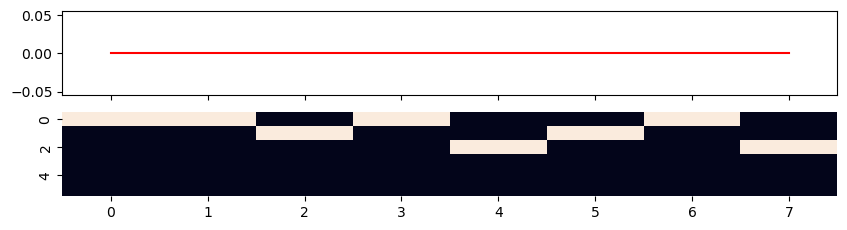

ap_scores = tensor([0.0000, 0.0005, 0.0100, 0.0514, 0.0997, 0.0725, 0.0369, 0.0861]) tensor(0.0446)


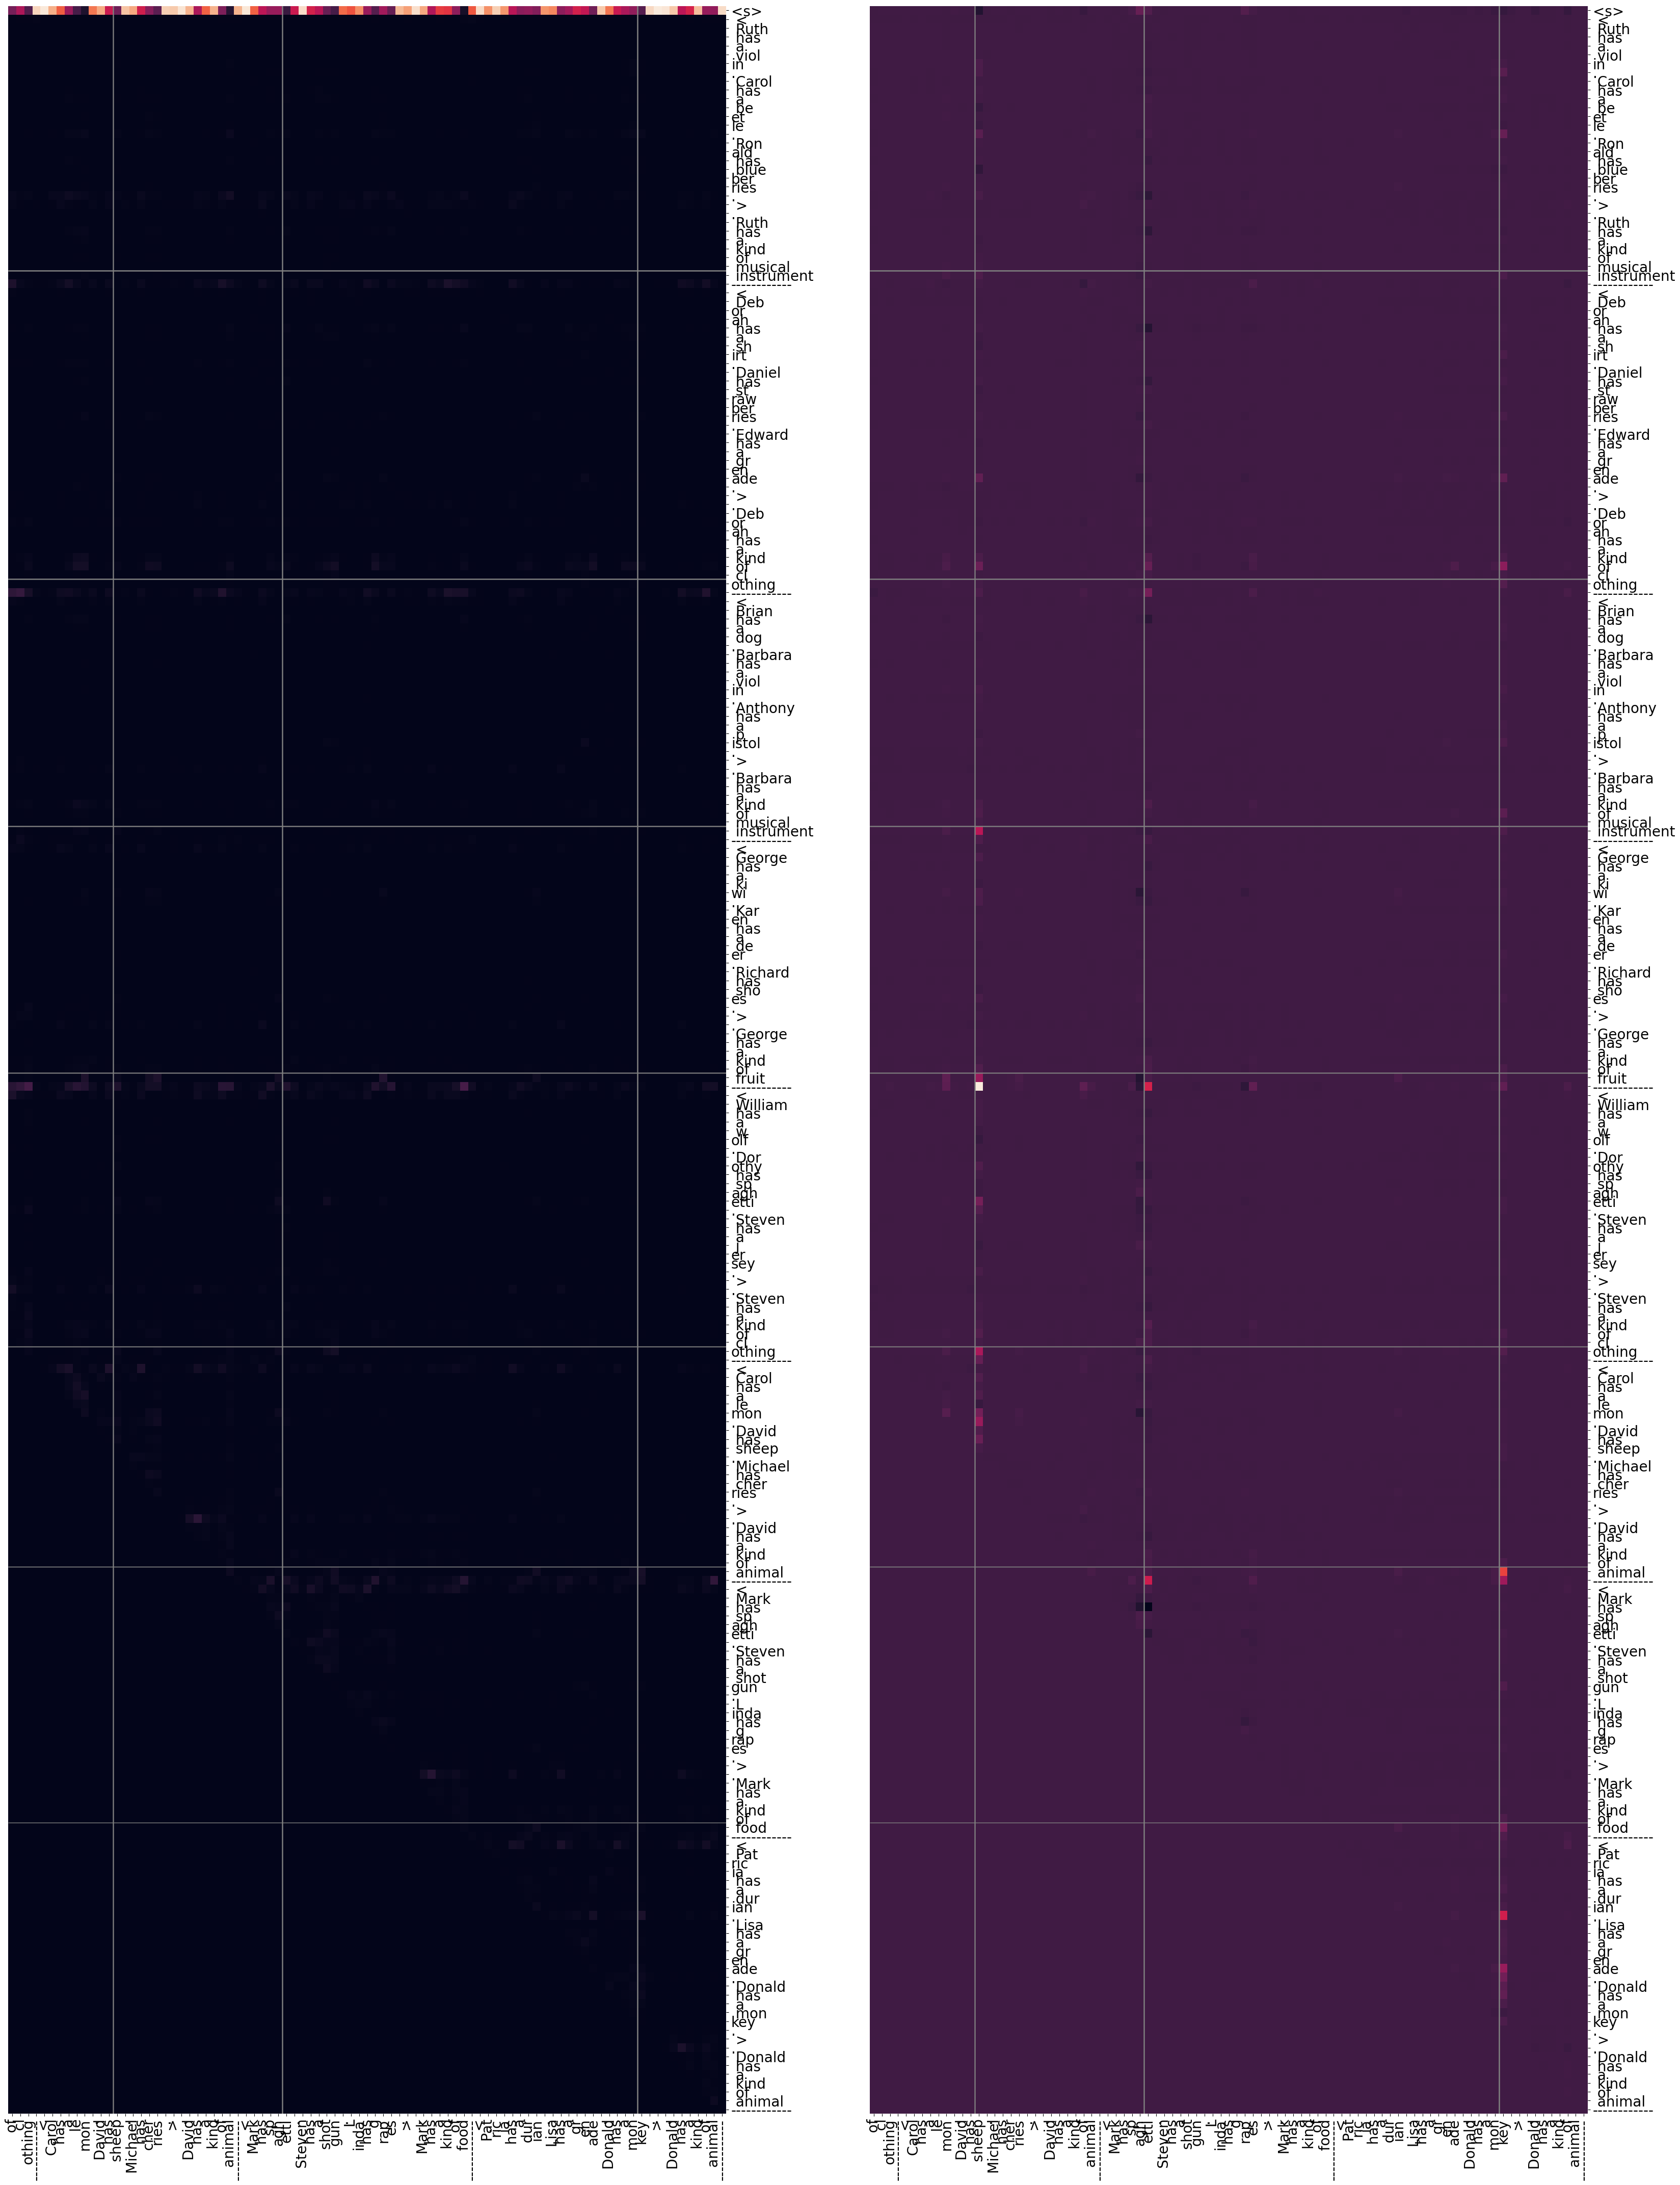

scaled_logprobs = tensor([-10.3750, -10.3750, -10.3750, -10.3750, -10.3750, -10.3750, -10.3750,
        -10.3750], device='cuda:1', dtype=torch.float16)
 ▁drink 0.0 {'▁ur': 0.0, '▁well': 0.0, '▁pitch': 0.0, 'hum': 0.0} 	 < James has trousers. Donald has a revolver. Mark has juice. >. Mark possesses a kind of drink ▁mental:0.003 ▁cl:-0.000 *▁drink:0.000 ▁weapon:0.001
 ▁drink 0.0 {'▁empty': 0.0, 'ship': 0.0, '▁ful': 0.0, '▁handled': 0.0} 	  < Brian has an apricot. Carol has cake. Laura has tea. >. Laura possesses a kind of drink ▁ful:0.007 *▁drink:-0.000 ▁fruit:0.000 ▁food:-0.001
 ▁food 0.0 {'▁pl': 0.0, 'op': 0.0, '▁ful': 0.0, '▁Vict': 0.0} 	  < Betty has bread. Donald has a banana. Linda has a shotgun. >. Betty possesses a kind of food ▁Sent:0.010 ▁weapon:-0.000 ▁fruit:-0.003 *▁food:0.001
 ▁animal 0.0 {'Serial': 0.0, 'hl': 0.0, 'HL': 0.0, '▁VALUES': 0.0} 	  < Robert has vodka. Jennifer has a wolf. Mark has a cocktail. >. Jennifer possesses a kind of animal enia:0.006 *▁animal:-0.000 ▁dr

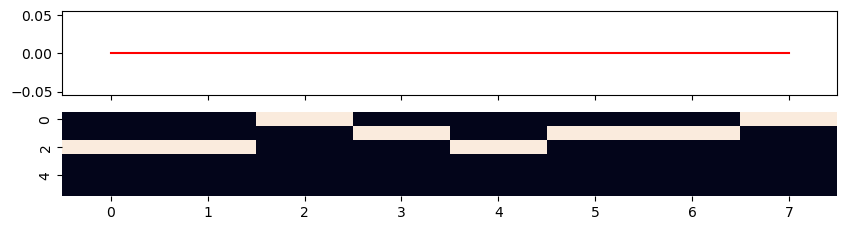

ap_scores = tensor([0.0000, 0.0159, 0.0718, 0.0740, 0.1139, 0.0618, 0.0576, 0.0611]) tensor(0.0570)


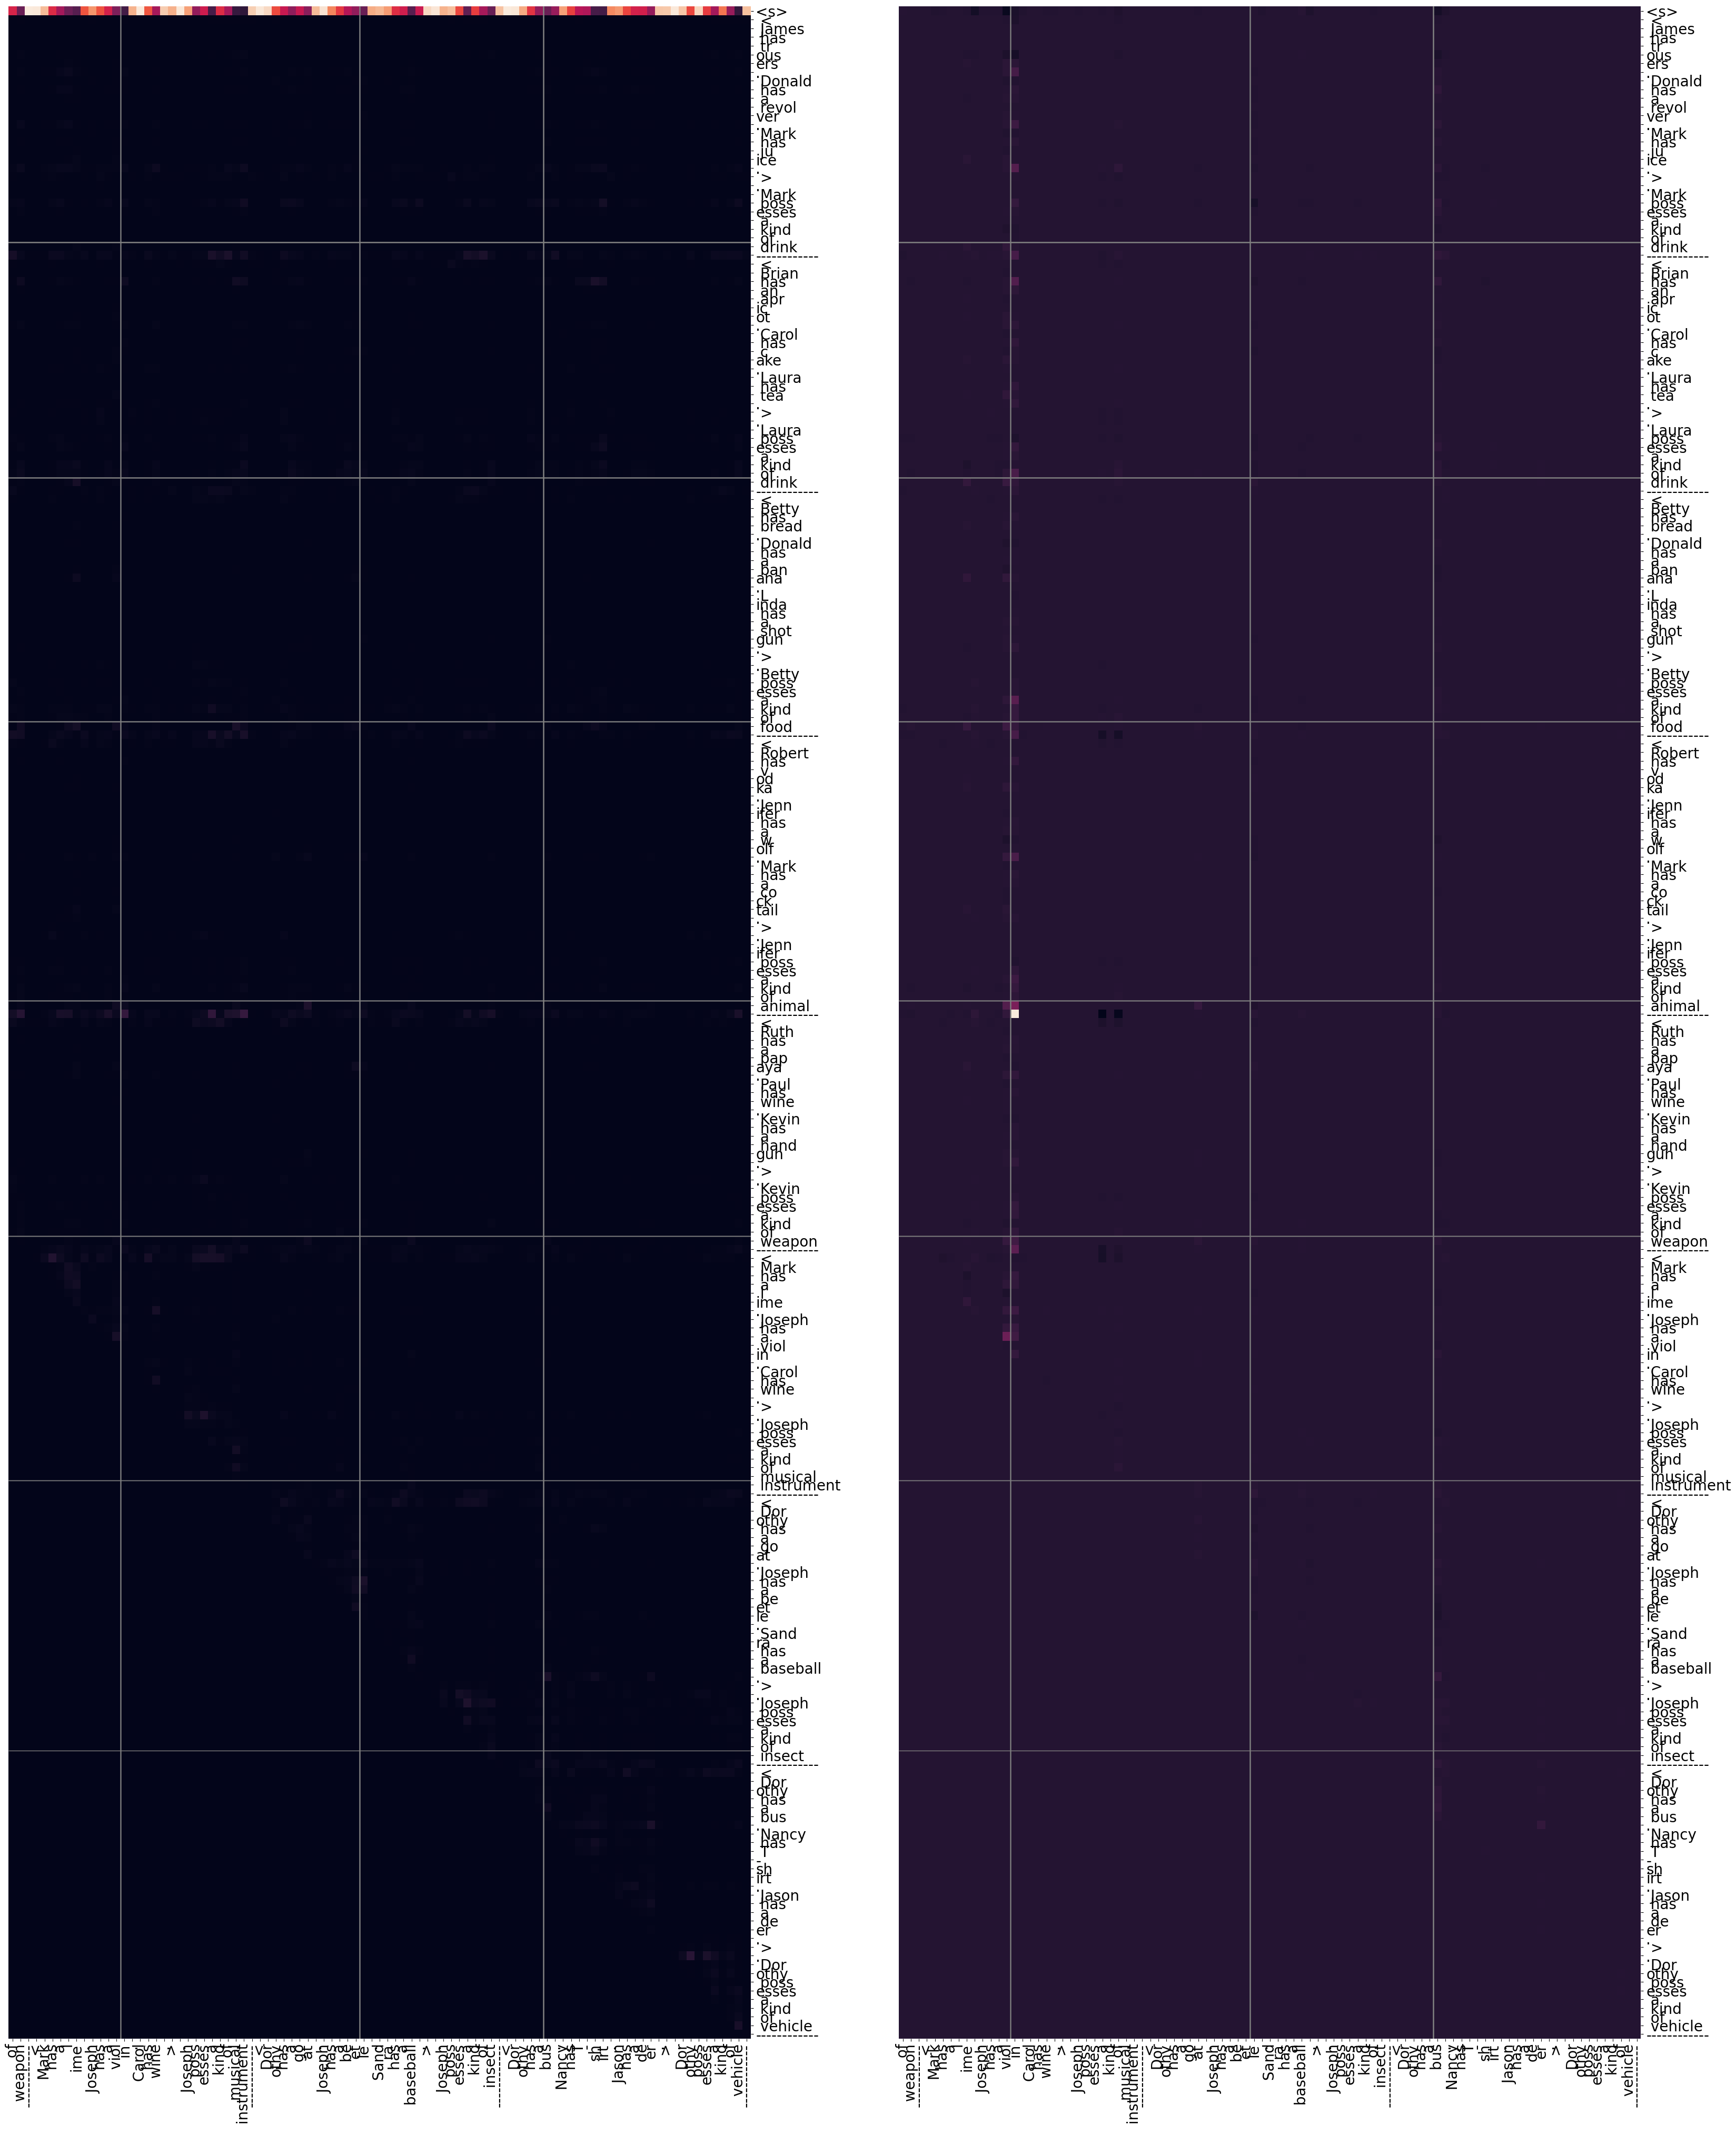

scaled_logprobs = tensor([-10.3750, -10.3750, -10.3750, -10.3750, -10.3672, -10.3672, -10.3672,
        -10.3672], device='cuda:1', dtype=torch.float16)
 ▁drink 0.0 {'ula': 0.0, 'rix': 0.0, 'rim': 0.0, 'usz': 0.0} 	 < David has a deer. Lisa has juice. Jeff has a baseball. >. Lisa owns a kind of drink ▁animal:-0.000 *▁drink:-0.001 ▁sport:0.001 oga:0.004
 ▁weapon 0.0 {'▁Pract': 0.0, '▁practice': 0.0, '▁pract': 0.0, '▁ar': 0.0} 	  < John has a grenade. Patricia has a peach. Anthony has tea. >. John owns a kind of weapon ▁Pract:0.005 ▁drink:-0.001 ▁fruit:-0.003 *▁weapon:0.002
*▁sport 0.0 {'▁Sport': 0.0, '▁sport': 0.0, 'pert': 0.0, '▁Sports': 0.0} 	  < Joseph has wine. John has a plum. Mark has a football. >. Mark owns a kind of sport ▁amateur:0.008 ▁drink:0.000 ▁fruit:-0.002 *▁sport:0.007
 ▁cl 0.0 {'▁Sample': 0.0, '▁sex': 0.0, '▁Sex': 0.0, '▁Singles': 0.0} 	  < Paul has a costume. Barbara has an elephant. Anthony has a taxi. >. Paul owns a kind of clothing *▁cl:0.007 ▁vehicle:-0.006 ▁sex:0

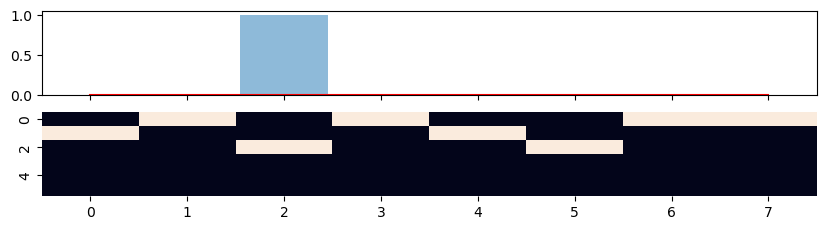

ap_scores = tensor([0.0000, 0.0042, 0.0352, 0.0425, 0.1081, 0.0355, 0.1390, 0.0910]) tensor(0.0569)


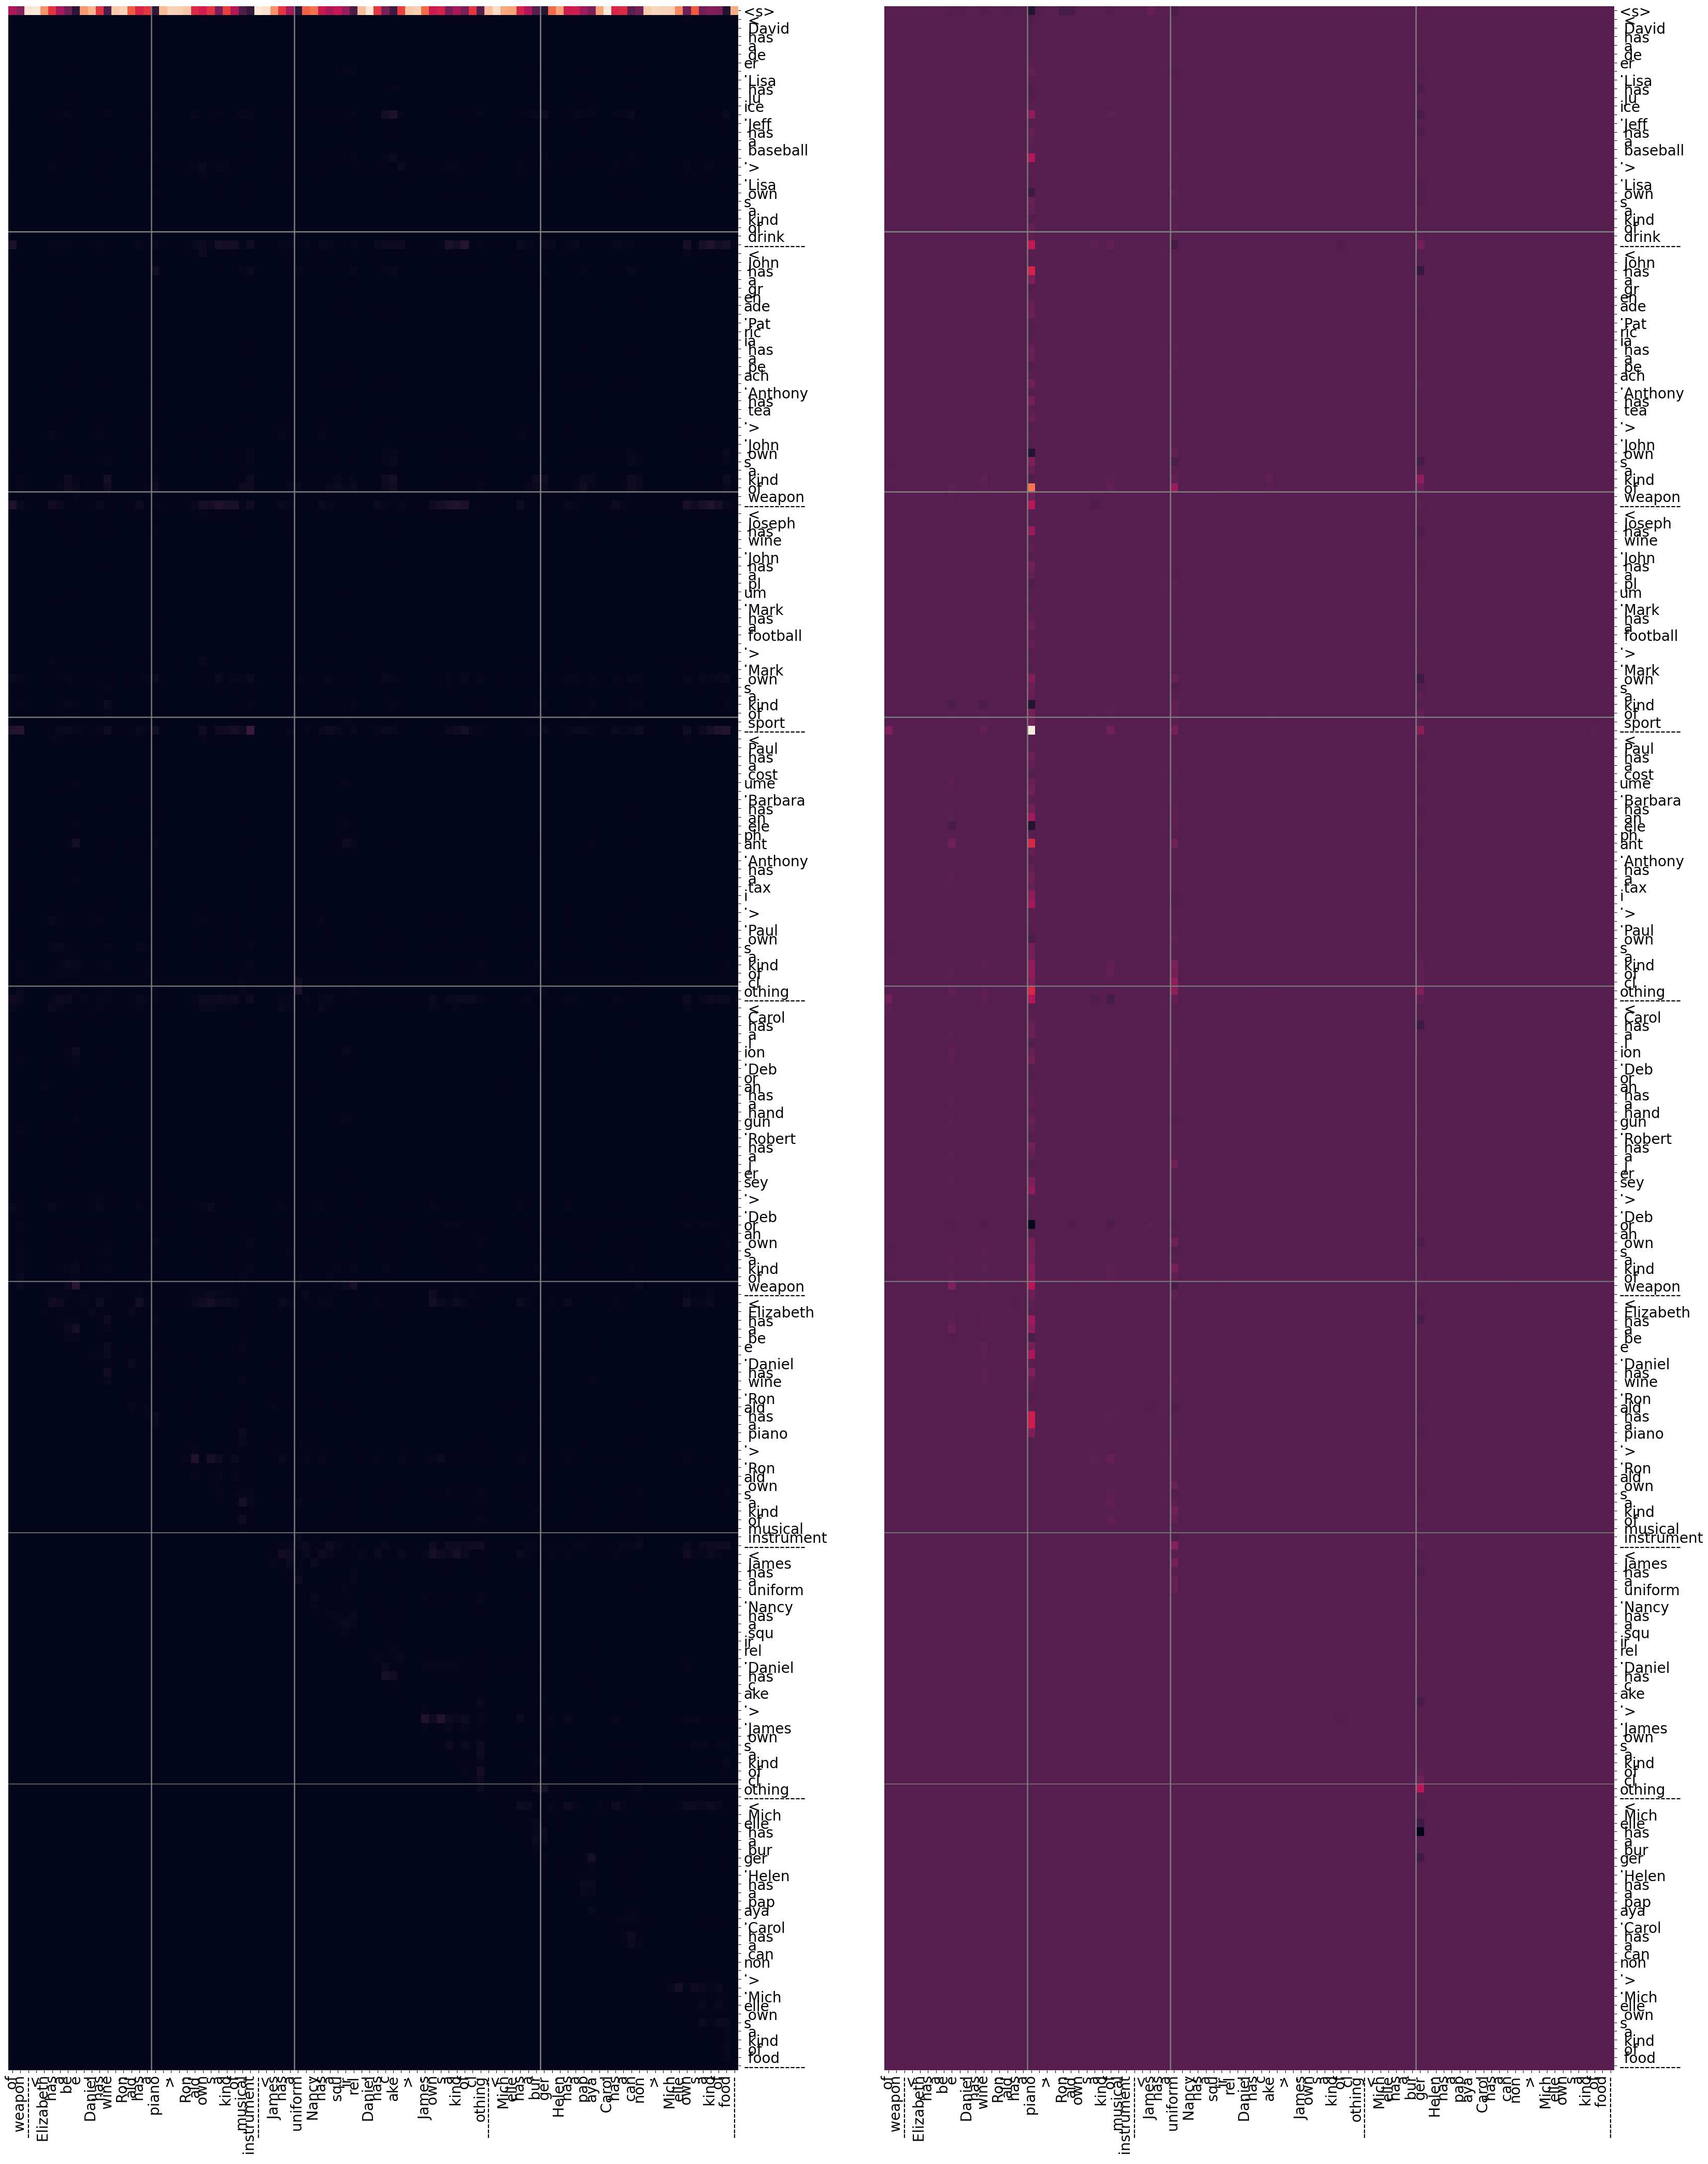

scaled_logprobs = tensor([-10.3750, -10.3750, -10.3750, -10.3750, -10.3750, -10.3750, -10.3750,
        -10.3750], device='cuda:1', dtype=torch.float16)
 ▁sport 0.0 {'ossa': 0.0, 'oga': 0.0, 'layout': 0.0, '<0x04>': 0.0} 	 < Steven has a football. Mark has a mosquito. Donald has grapes. >. Steven owns a kind of sport layout:0.003 ▁insect:-0.001 *▁sport:0.000 ▁fruit:-0.000
 ▁animal 0.0 {'da': 0.0, '▁stat': 0.0, 'angu': 0.0, 'result': 0.0} 	  < Maria has a dog. Patricia has a cocktail. Elizabeth has a gun. >. Maria owns a kind of animal ▁editor:0.005 *▁animal:-0.000 ▁drink:-0.002 ▁weapon:-0.002
 ▁cl 0.0 {'▁mismatch': 0.0, '▁frames': 0.0, 'seg': 0.0, '▁cl': 0.0} 	  < Lisa has an apricot. Patricia has pants. Sharon has blueberries. >. Patricia owns a kind of clothing ▁frames:0.007 *▁cl:0.005 ▁fruit:-0.002
 ▁food 0.0 {'▁request': 0.0, 'alse': 0.0, 'ties': 0.0, 'Request': 0.0} 	  < Linda has underwear. Sharon has a papaya. William has spaghetti. >. William owns a kind of food ella:0.006 ▁cl:

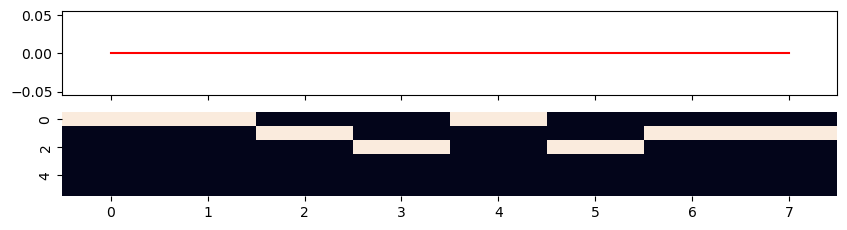

ap_scores = tensor([0.0000, 0.0068, 0.0094, 0.0100, 0.0681, 0.0234, 0.0566, 0.0563]) tensor(0.0288)


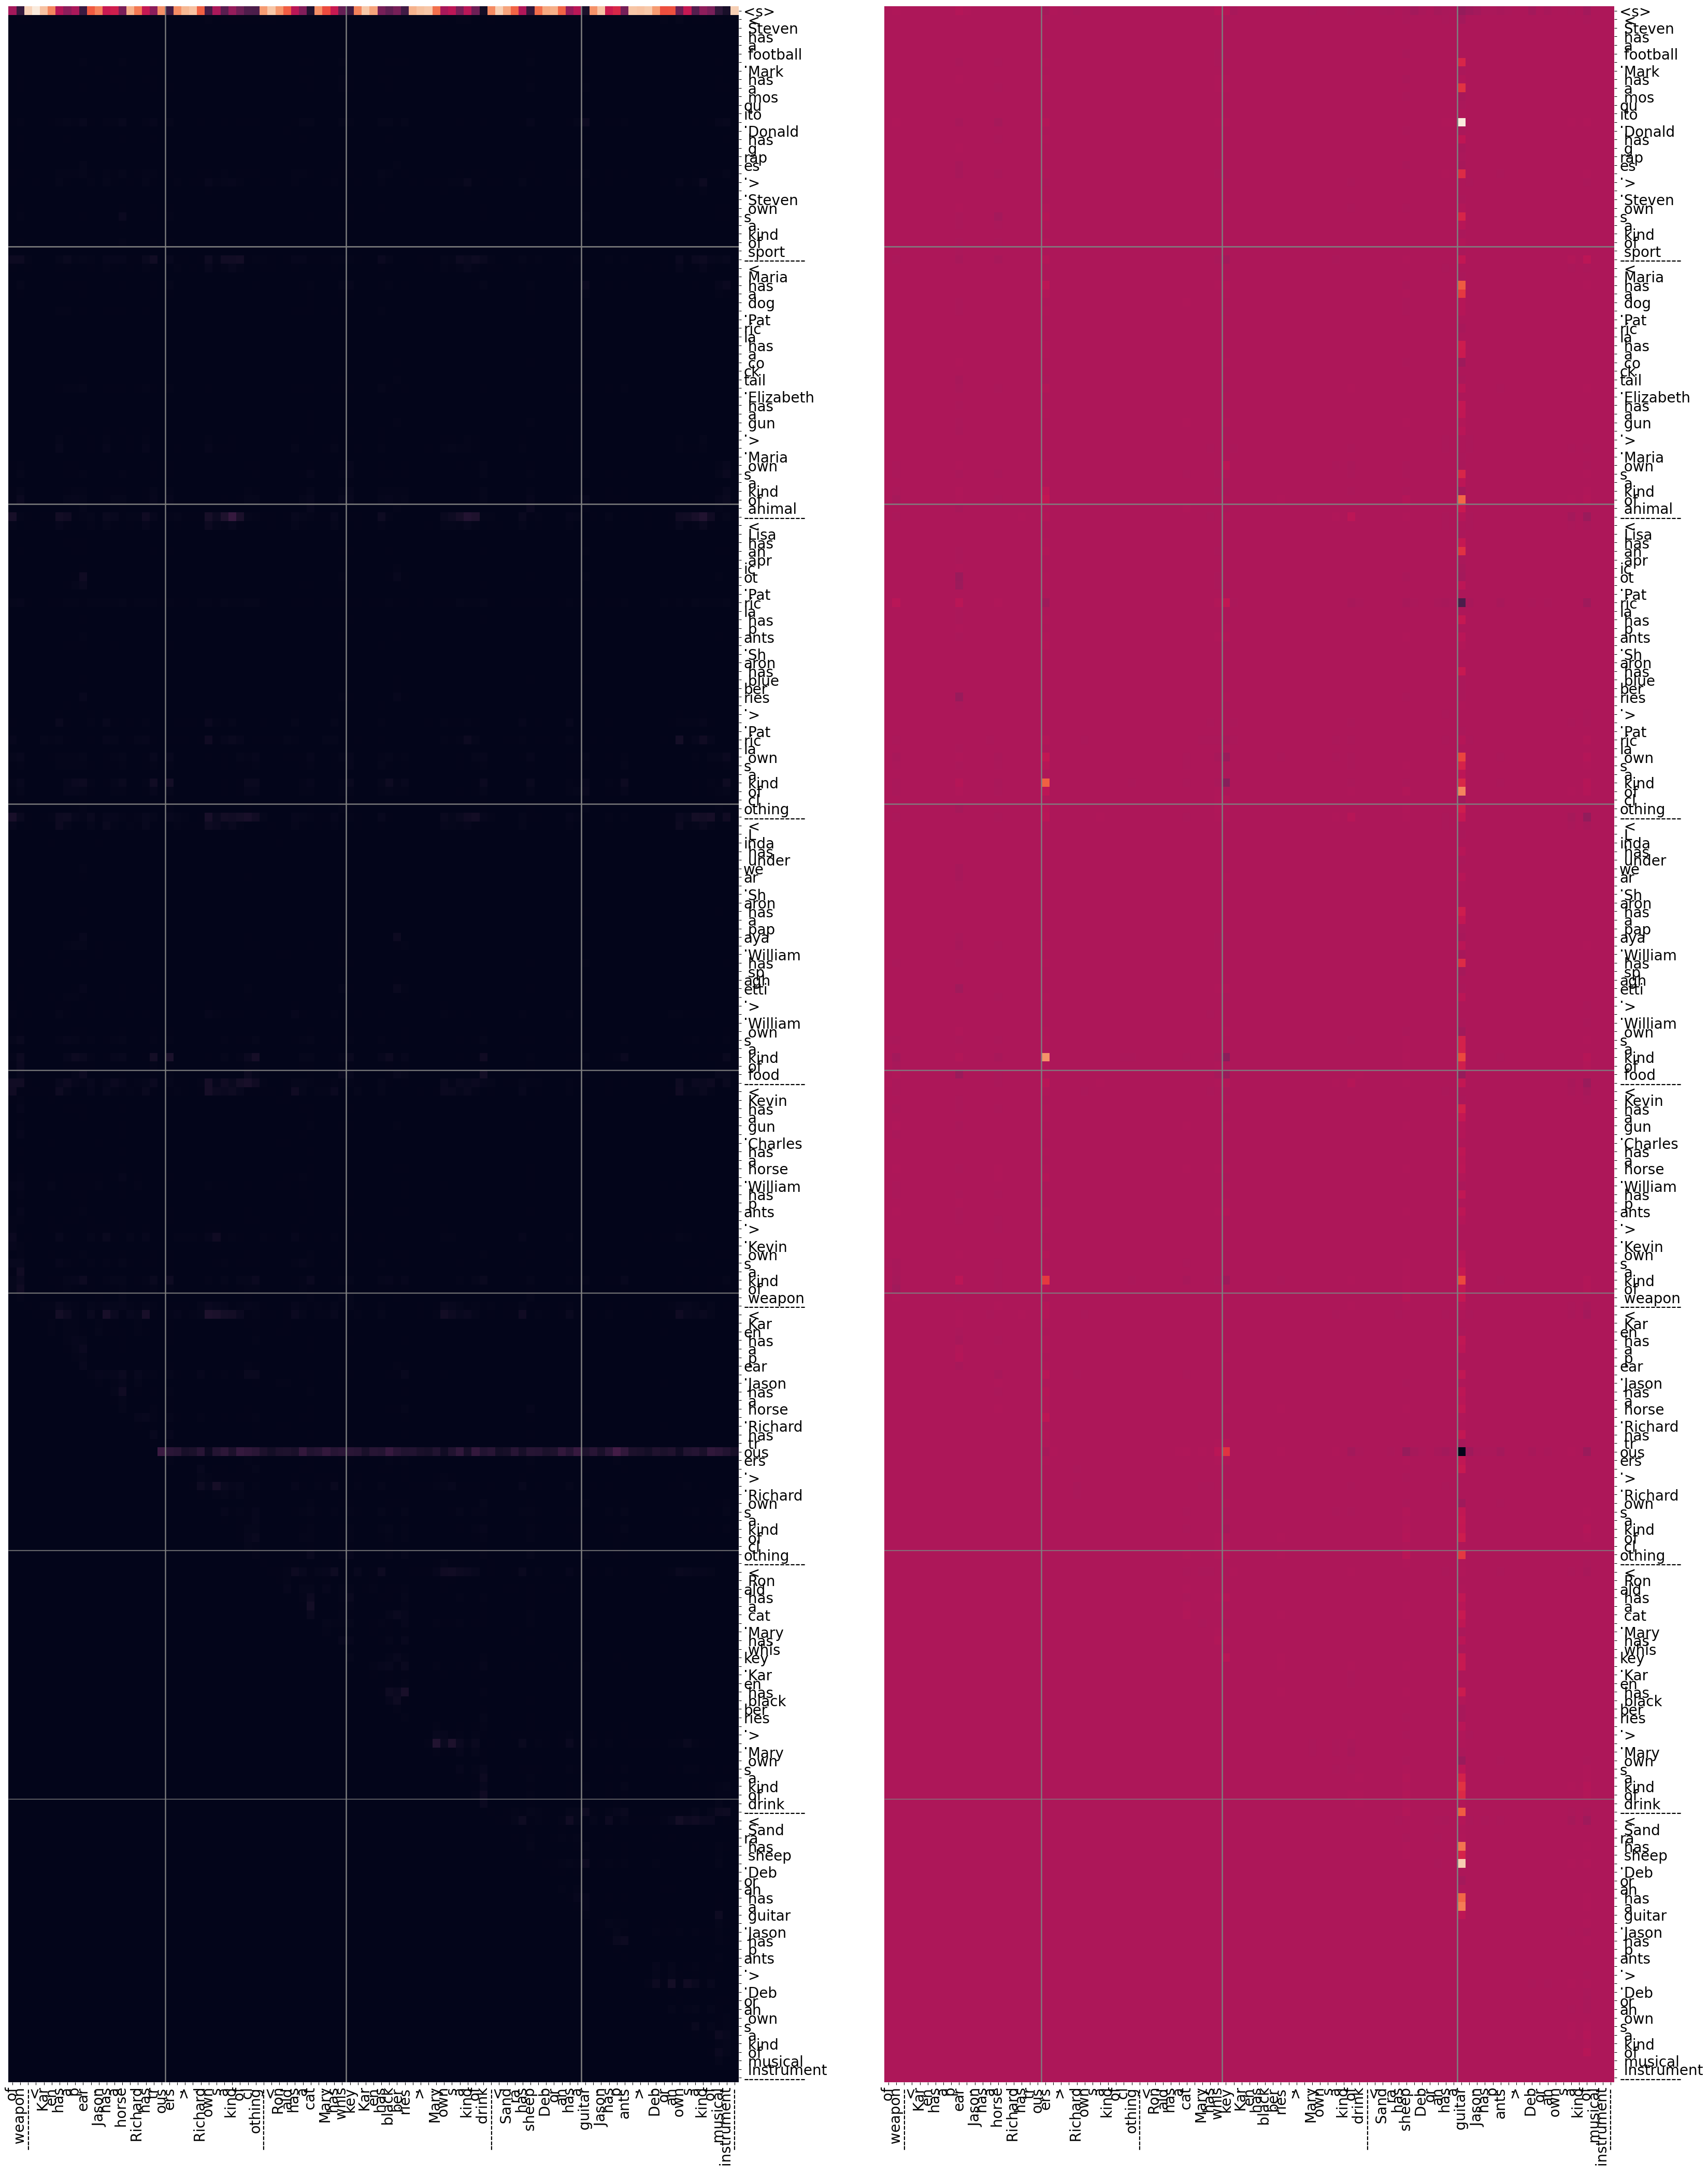

scaled_logprobs = tensor([-10.3750, -10.3750, -10.3750, -10.3750, -10.3750, -10.3750, -10.3750,
        -10.3750], device='cuda:1', dtype=torch.float16)
 ▁drink 0.0 {'▁one': 0.0, 'ag': 0.0, 'ale': 0.0, 'own': 0.0} 	 < Michael has a basketball. Brian has beer. Anthony has a cat. >. Brian possesses a kind of drink *▁drink:-0.001 ▁animal:-0.000 ▁sport:0.001 ▁Ward:0.004
 ▁animal 0.0 {'▁casting': 0.0, '▁Laz': 0.0, '▁assigning': 0.0, 'preview': 0.0} 	  < Kevin has an elephant. Mark has a violin. Margaret has spaghetti. >. Kevin possesses a kind of animal *▁animal:0.001 ▁musical:-0.003 ▁casting:0.007 ▁food:-0.001
 ▁weapon 0.0 {'▁position': 0.0, 'angu': 0.0, '▁eng': 0.0, 'ship': 0.0} 	  < Karen has a rifle. Lisa has a car. Margaret has a cocktail. >. Karen possesses a kind of weapon ▁drink:-0.001 ▁vehicle:-0.003 ▁position:0.006 *▁weapon:-0.000
 ▁weapon 0.0 {'▁pitch': 0.0, 'amt': 0.0, 'ach': 0.0, 'itt': 0.0} 	  < Edward has a horse. Elizabeth has shoes. Susan has a gun. >. Susan possesses a kin

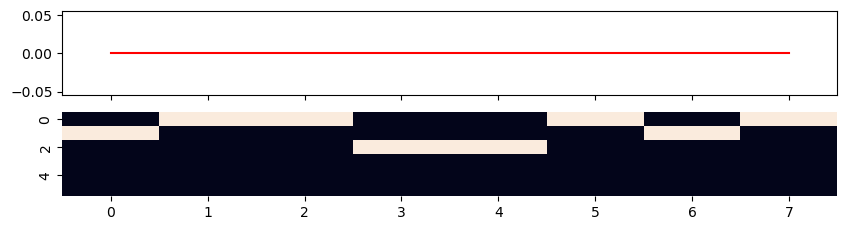

ap_scores = tensor([0.0000, 0.0056, 0.0420, 0.0471, 0.1058, 0.1324, 0.0978, 0.1781]) tensor(0.0761)


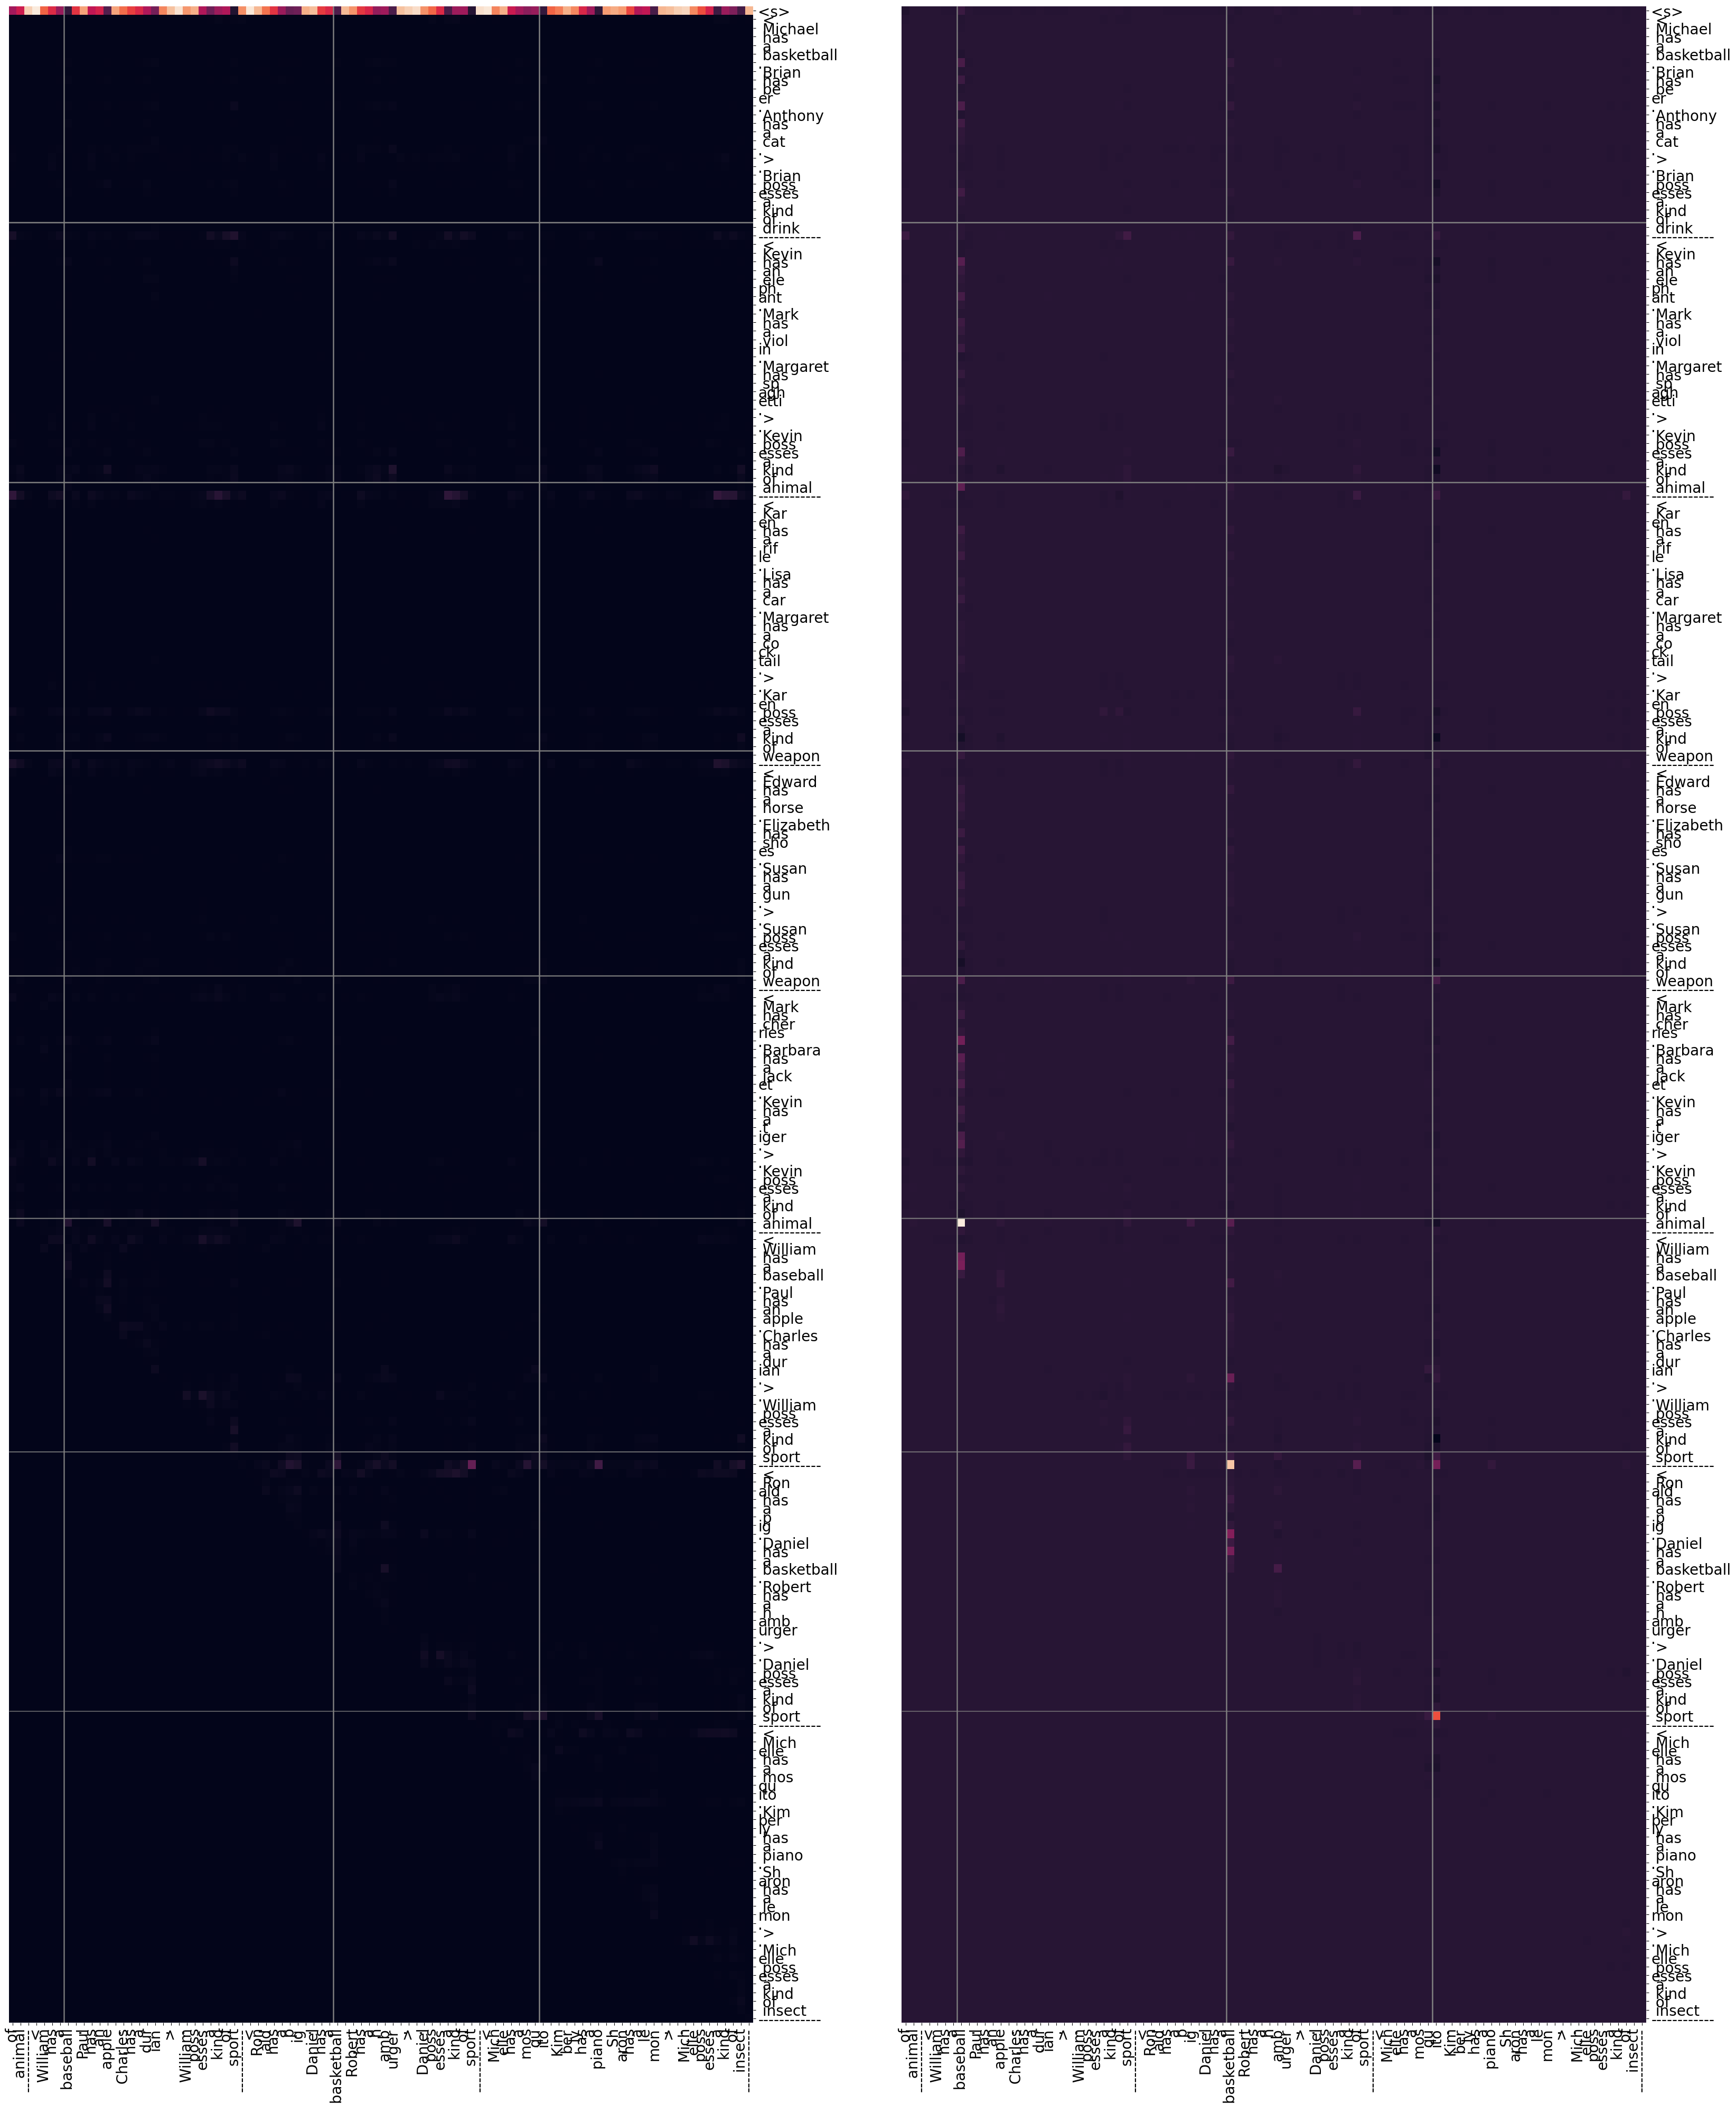

scaled_logprobs = tensor([-10.3750, -10.3750, -10.3750, -10.3750, -10.3750, -10.3750, -10.3750,
        -10.3750], device='cuda:1', dtype=torch.float16)
 ▁animal 0.0 {'vo': 0.0, '▁vo': 0.0, 'onde': 0.0, 'oga': 0.0} 	 < Edward has a plum. Donald has sheep. Daniel has a bus. >. Donald possesses a kind of animal *▁animal:0.001 ▁vehicle:-0.001 ▁fruit:-0.000 oga:0.003
 ▁fruit 0.0 {'▁singular': 0.0, '▁pl': 0.0, '▁p': 0.0, 'ont': 0.0} 	  < Joseph has T-shirt. Deborah has an apple. Sharon has underwear. >. Deborah possesses a kind of fruit ▁singular:0.006 ▁cl:0.000 *▁fruit:-0.000
 ▁animal 0.0 {'▁stat': 0.0, 'lide': 0.0, '▁Stat': 0.0, 'aur': 0.0} 	  < Nancy has an elephant. Ronald has a mango. Mary has a rifle. >. Nancy possesses a kind of animal ▁stat:0.009 *▁animal:0.001 ▁fruit:-0.002 ▁weapon:-0.003
 ▁musical 0.0 {'▁pt': 0.0, '▁int': 0.0, '<0xAA>': 0.0, 'ps': 0.0} 	  < Jennifer has a baseball. David has vodka. Edward has a violin. >. Edward possesses a kind of musical instrument ▁pt:0.006 ▁dr

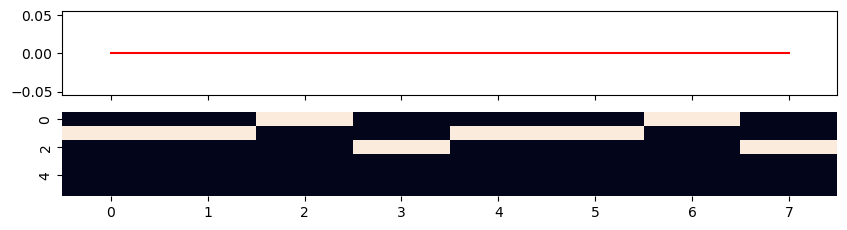

ap_scores = tensor([0.0000, 0.0327, 0.0184, 0.0973, 0.1493, 0.0496, 0.0995, 0.0391]) tensor(0.0607)


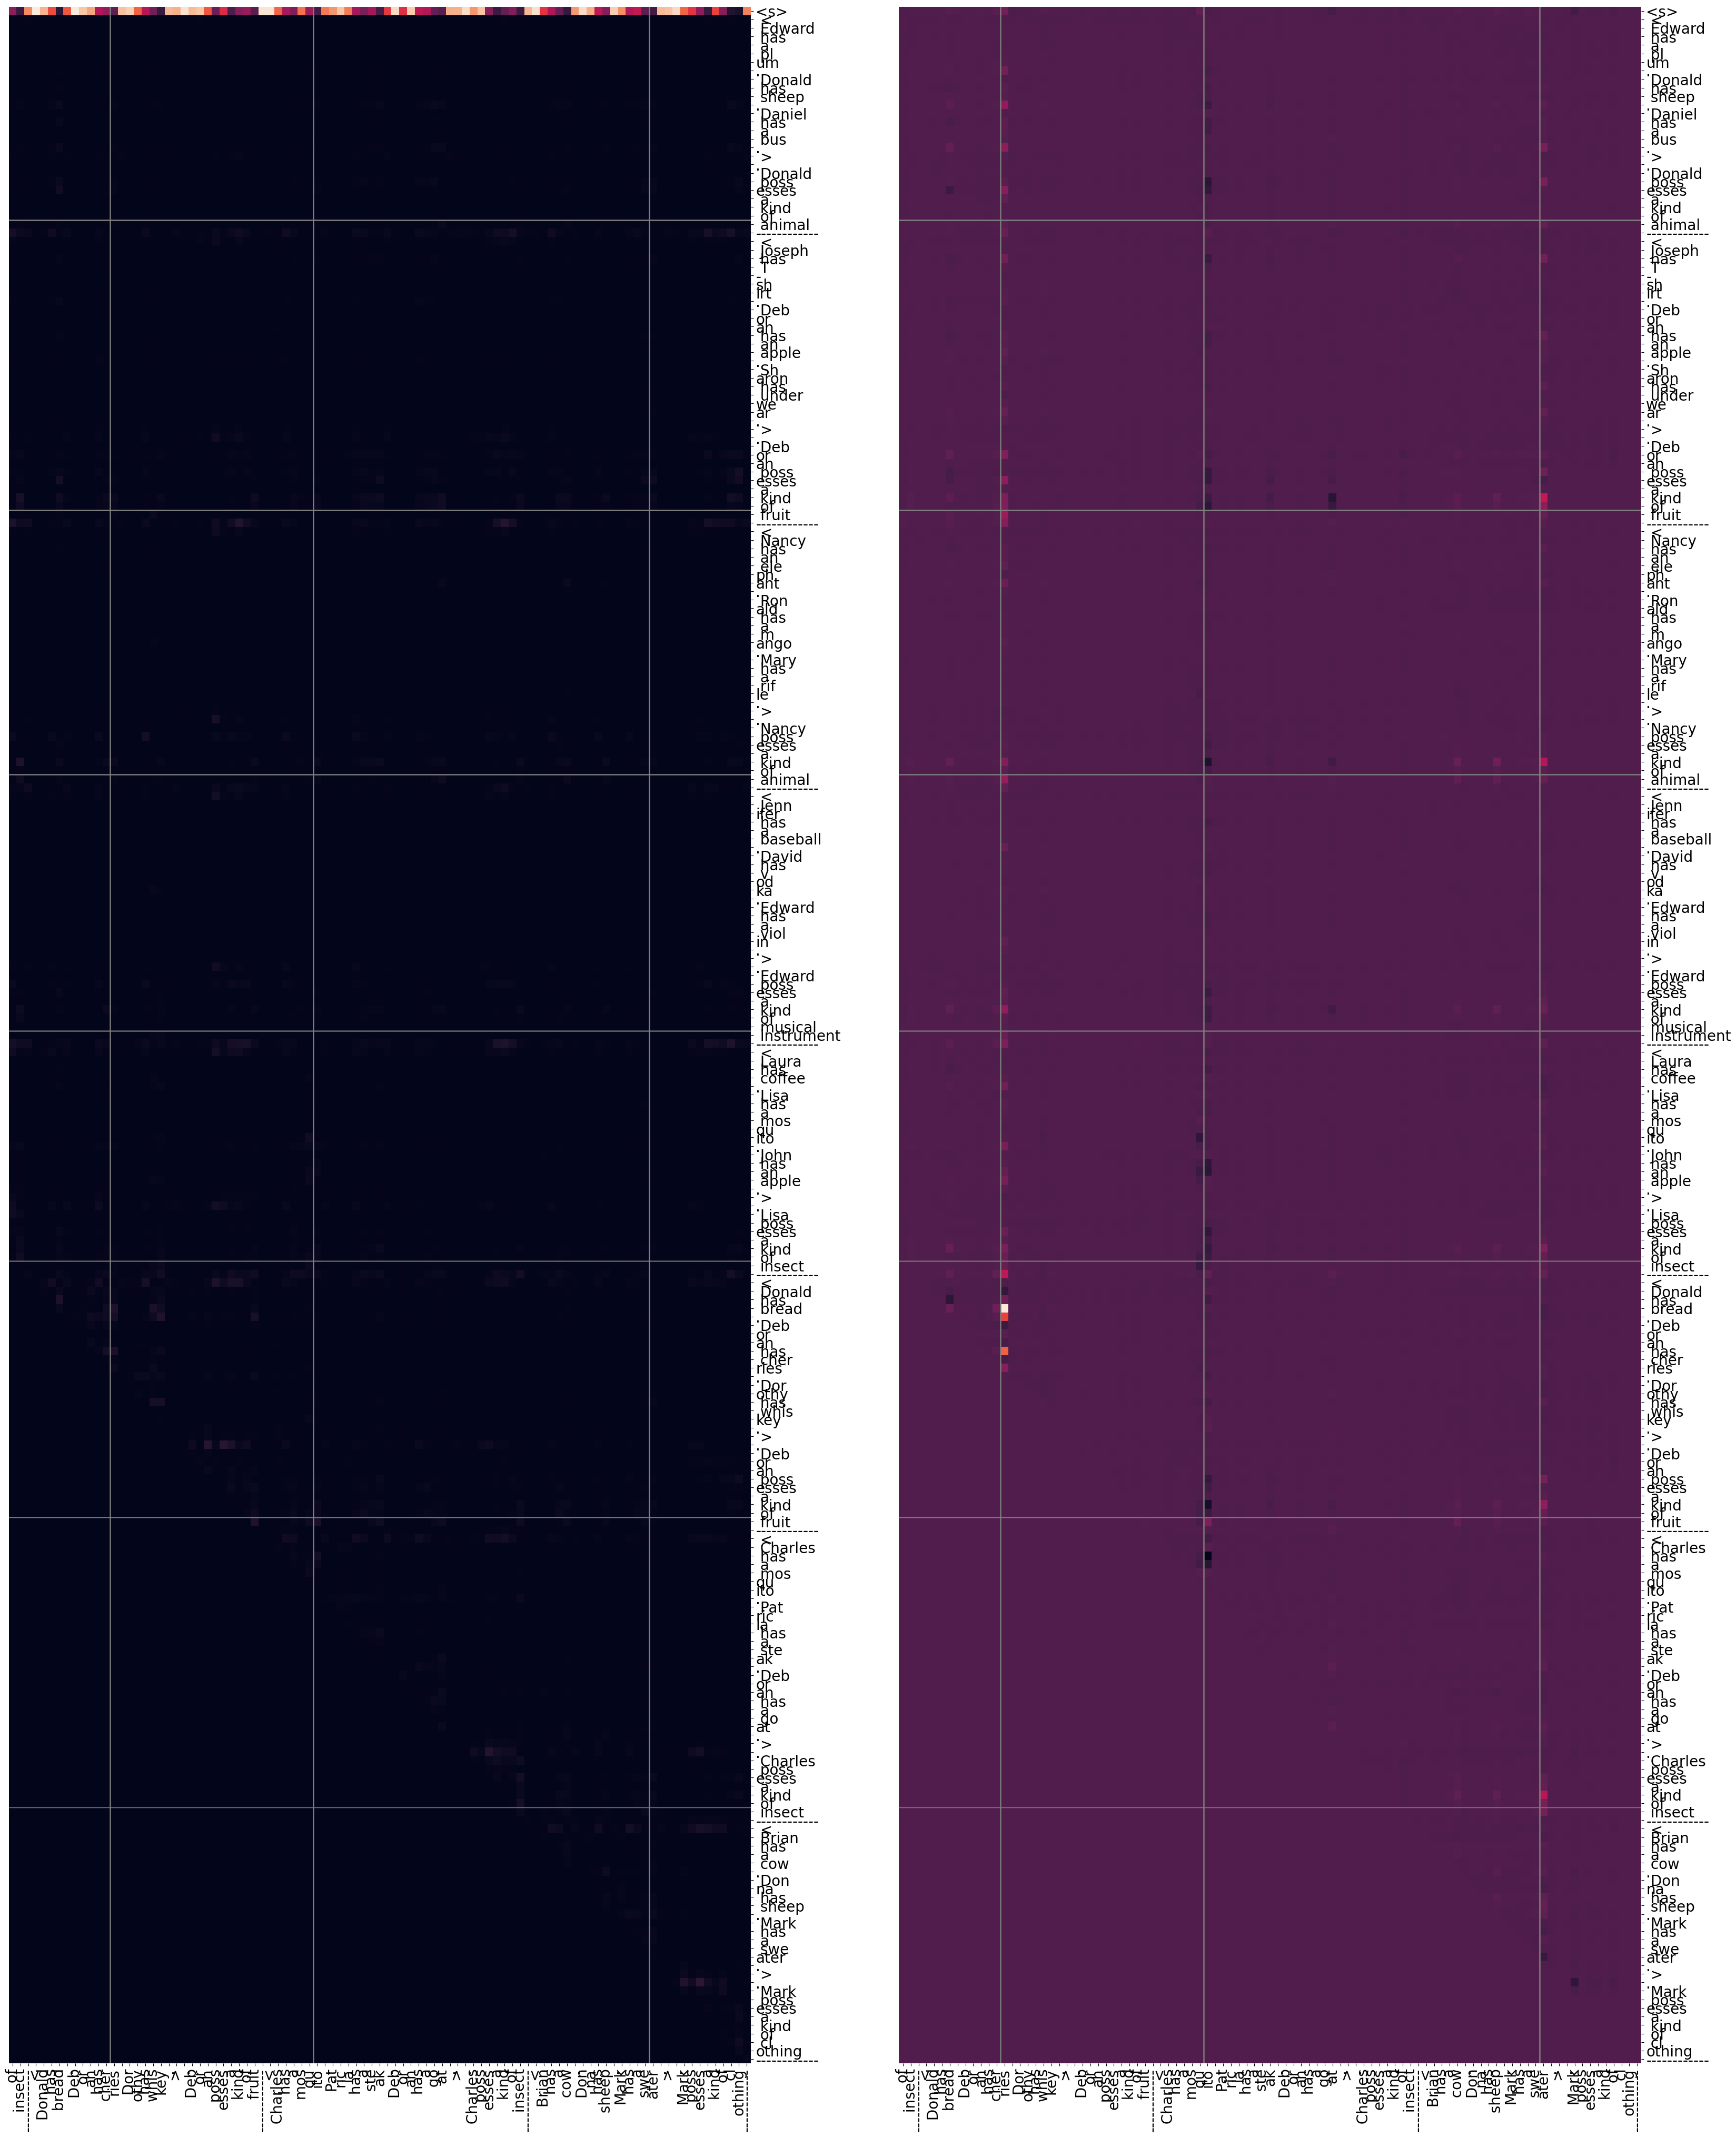

scaled_logprobs = tensor([-10.3750, -10.3750, -10.3750, -10.3750, -10.3750, -10.3672, -10.3672,
        -10.3672], device='cuda:1', dtype=torch.float16)
 ▁musical 0.0 {'<0x00>': 0.0, '</s>': 0.0, '<0x0B>': 0.0, '<0x10>': 0.0} 	 < Susan has a squirrel. Sandra has a grenade. Helen has a violin. >. Helen possesses a kind of musical instrument ▁animal:-0.001 *▁musical:-0.001 ▁flat:0.002 ▁weapon:-0.001
 ▁food 0.0 {'▁struggle': 0.0, 'ella': 0.0, 'ball': 0.0, 'ra': 0.0} 	  < Elizabeth has spaghetti. Margaret has T-shirt. Nancy has a grenade. >. Elizabeth possesses a kind of food ▁weapon:-0.004 ▁cl:-0.001 ella:0.007 *▁food:-0.004
 ▁fruit 0.0 {'▁ju': 0.0, '▁pl': 0.0, '▁yield': 0.0, '▁vit': 0.0} 	  < Kimberly has a guitar. Jeff has blackberries. Thomas has a monkey. >. Jeff possesses a kind of fruit ▁animal:0.002 ▁musical:-0.004 *▁fruit:0.003 ▁ju:0.009
 ▁weapon 0.0 {'▁insert': 0.0, 'ball': 0.0, '▁Service': 0.0, '▁vál': 0.0} 	  < Thomas has a grenade. Carol has a deer. Ruth has a costume. >. Thom

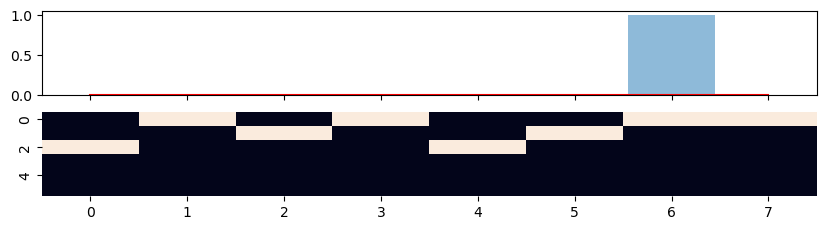

ap_scores = tensor([0.0000, 0.0069, 0.0397, 0.0153, 0.0337, 0.0318, 0.0287, 0.0293]) tensor(0.0232)


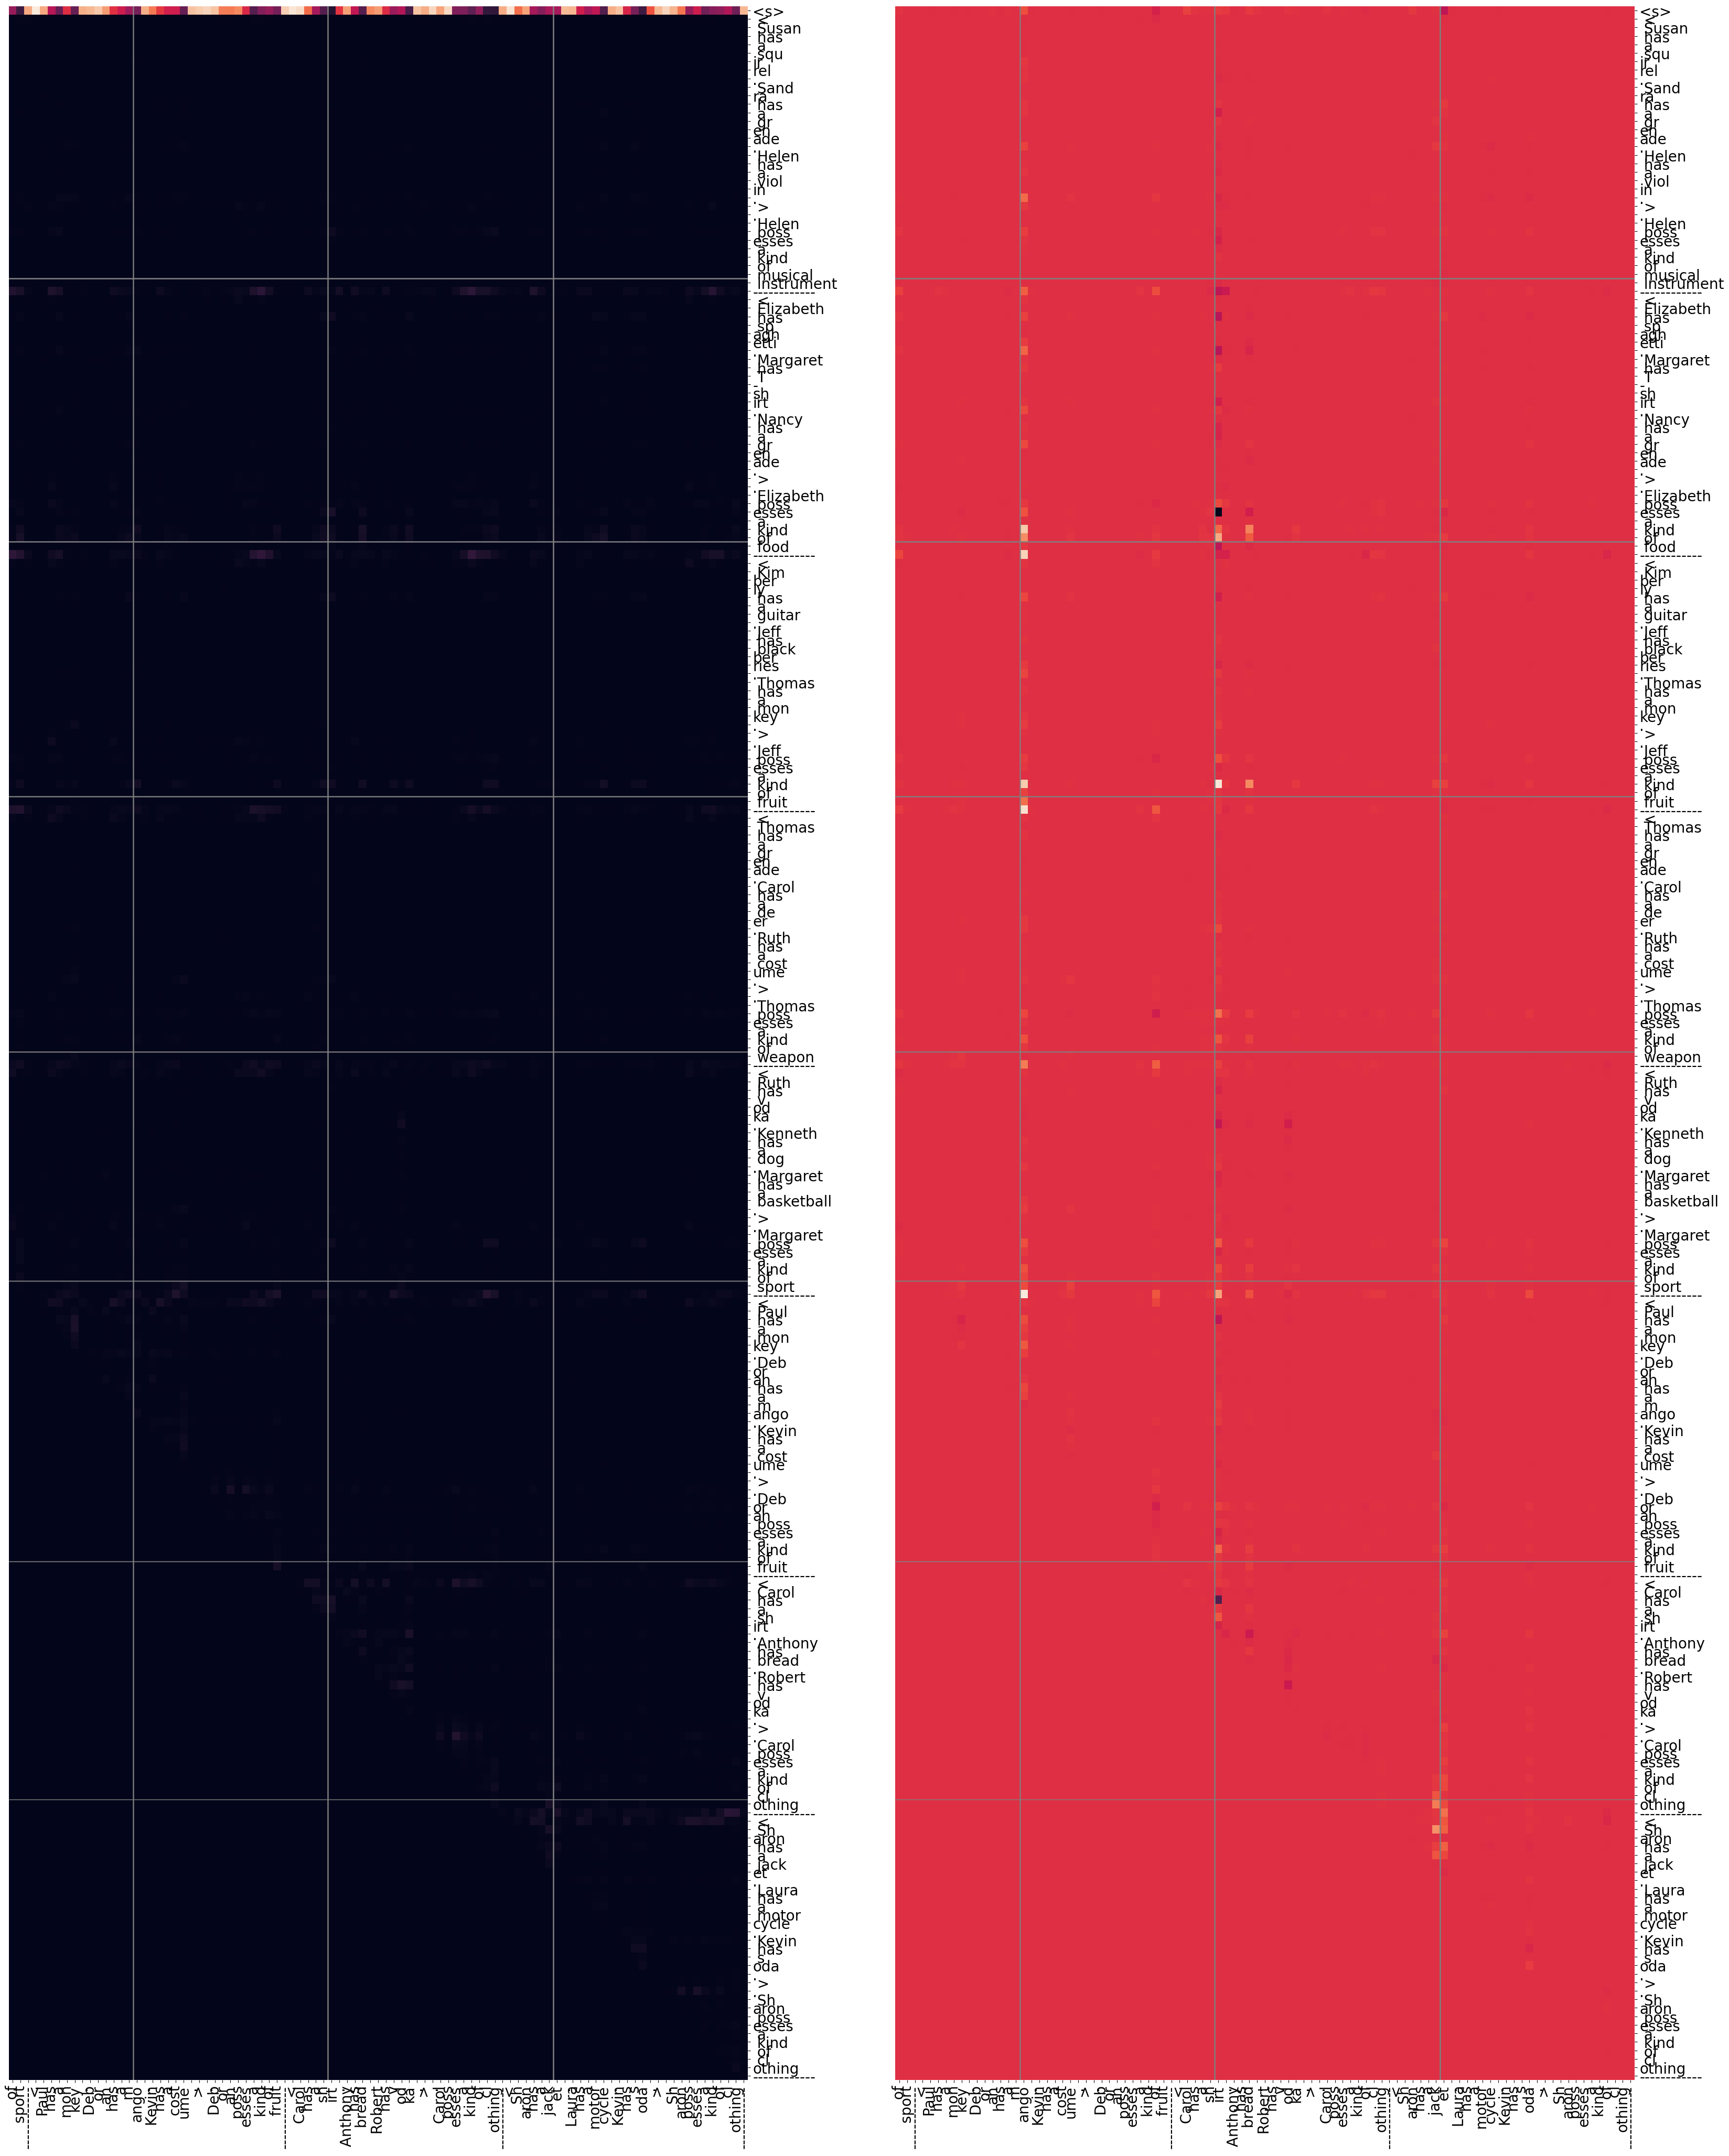

scaled_logprobs = tensor([-10.3750, -10.3750, -10.3750, -10.3750, -10.3750, -10.3750, -10.3750,
        -10.3750], device='cuda:1', dtype=torch.float16)
 ▁musical 0.0 {'impl': 0.0, 'Des': 0.0, '▁floating': 0.0, '▁Ward': 0.0} 	 < William has a bee. Edward has a cow. Sharon has a piano. >. Sharon possesses a kind of musical instrument *▁musical:-0.002 ▁animal:-0.001 ▁insect:-0.001 perp:0.002
 ▁animal 0.0 {'▁push': 0.0, 'lo': 0.0, 'ad': 0.0, 'te': 0.0} 	  < Mary has a tiger. Charles has a durian. Sharon has a revolver. >. Mary possesses a kind of animal ▁push:0.004 *▁animal:0.000 ▁fruit:-0.000 ▁weapon:-0.001
 ▁drink 0.0 {'▁cultiv': 0.0, '▁intens': 0.0, '▁synd': 0.0, '▁reson': 0.0} 	  < Kenneth has juice. Edward has a guitar. Steven has blueberries. >. Kenneth possesses a kind of drink ▁musical:-0.001 *▁drink:-0.001 ▁fruit:0.003 ▁cultiv:0.008
 ▁sport 0.0 {'▁pt': 0.0, 'AD': 0.0, 'itt': 0.0, 'angu': 0.0} 	  < Barbara has a burger. Charles has a pig. Edward has a basketball. >. Edward possess

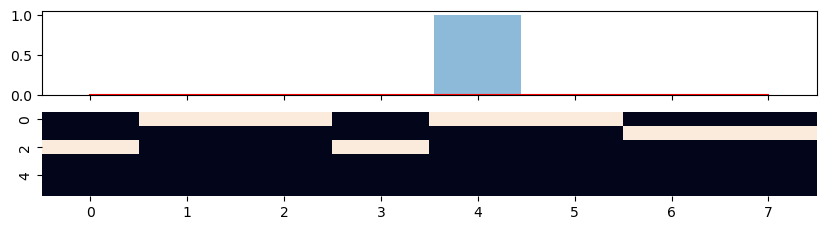

ap_scores = tensor([0.0000, 0.0049, 0.0055, 0.0325, 0.0101, 0.2040, 0.1019, 0.1105]) tensor(0.0587)


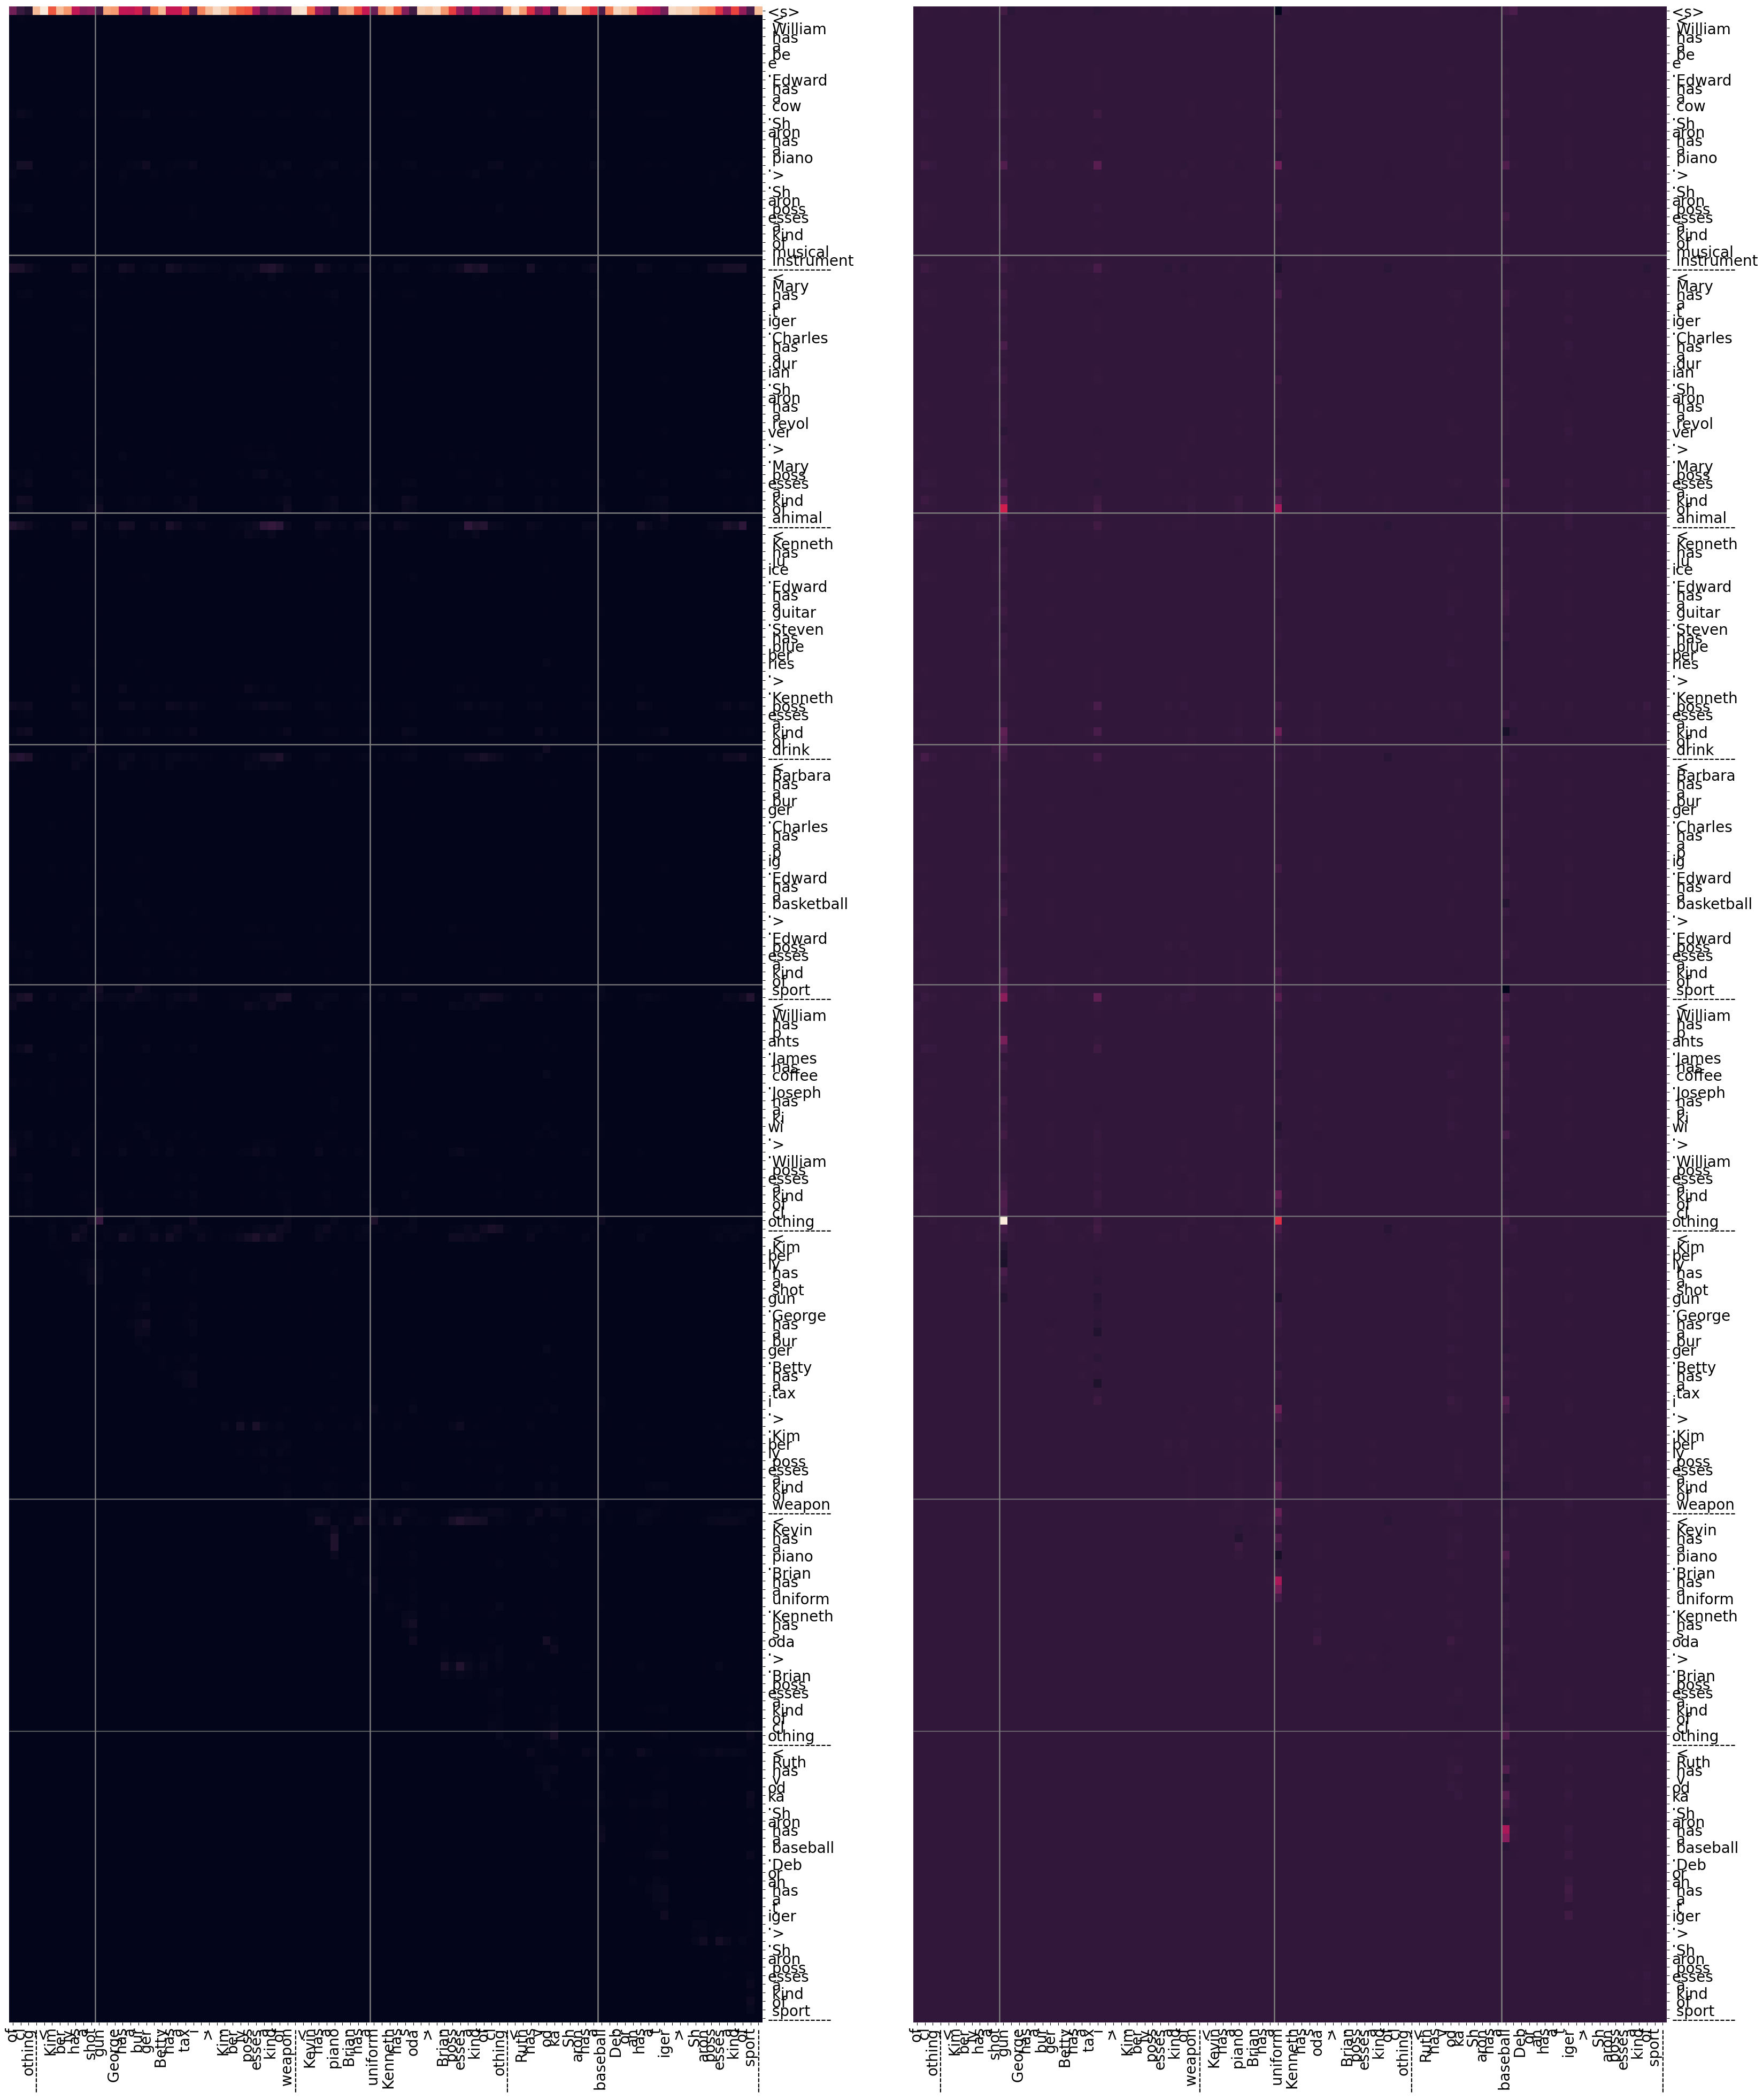

reduced_ap_scores = tensor([0.0000, 0.0097, 0.0290, 0.0463, 0.0861, 0.0764, 0.0772, 0.0814]) tensor(0.0508)


In [42]:
plot_attn_attrs(r.data_tuples[:], model, tokenizer, node, topi=[3], attn_patterns=['A0]->A]^'], is_relating_head=False, k_shot=k_shot+2, mix=False)

In [238]:
# import plotly.offline as pyo
# pyo.init_notebook_mode()

# from logits_dynamics import batch_logits_lens
# topk= model.transformer.wte.weight.data.shape[0]
# tgt = ['▁Yes', '▁No']
# fig1, fig2 = batch_logits_lens(r.data_tuples[0:1], model, tokenizer, heatmap=True,tgt=tgt, metric='target', case_sensitive=True, task_name='', topk=topk, verbose=False, orders=[1,2], scan_layer=[])
# fig1.show(), fig2.show()

In [29]:
#node是当前想查询节点的父节点，这里我们想查询'17-10,16-17,19-33 B->Q1'后面的@0 15-40 100 Q1->Q1 1/1/-1749,这个要定位到父节点，node.name=父节点
node = r.root.children[-1]; node.name
node.name
# node = r.root.children[-1].children[-1].children[-2]; node.name

'38-22,31-50,36-26 B->A^ attn'

In [17]:
print_tree(r.root)

 ┌@[3,4,5,7,9,10,11,12,13,14] 20-m,25-m,33-m,53-m,57-m,46-m,43-m,29-m 29,49-m 28,56-m 28 B->B 67
 ├@:3 36-26,38-22,31-50 B->A]^ 19
 ├@[6,8] 37-9,32-21 unk 0
 ├@3 20-m 75
 ├@4 25-m 50
 ├@5 33-m 47
 ├@7 53-m 38
 ├@9 57-m 34
 ├@10 46-m 32
 ├@11 43-m 31
 ├@12 29-m 29
 ├@13 49-m 28
 ├@14 56-m 28
 ├@0 36-26 100 B->A]^ 92/36 attn
 ├@1 38-22 95 B->A]^ 93/98 attn
 ├@2 31-50 77 B->A]^ 100/80 attn
 ├@6 37-9 43 B->B^ 90/52 attn
 ├@8 32-21 38 B->Q1 79/17/69 attn
 ├@8 32-21 38 B->Q1 79/17/69
 │                             ┌@[3,4,5,9,10,11,12] 27-m,25-m,28-m,29-m 26,24-m 25,31-m 22,23-m 21 B->B 48
 │                             ├@[0,1,2,6,7,13,14] 26-51,23-27,24-34,26-13 30,26-27 29,23-3 21,14-42 21 B->A]^ 42
 │                             ├@[8] 37-9 26 B->B^ 7
 │                             ├@3 27-m 38
 │                             ├@4 25-m 36
 │                             ├@5 28-m 31
 │                             ├@9 29-m 26
 │                             ├@10 24-m 25
 │                         

In [ ]:
all_examples, texts, all_bos_tokens = mathlogic_dataset
print('all_examples', all_examples, '\ntexts',texts,'\nall_bos_tokens',all_bos_tokens)

1.There are jersey<font color="#dd0000">(ans0)</font>,uniform<font color="#dd0000">(ans0)</font>,jeep.(sep) How many clothing(query) are there? Answer:(bos) Two(ans).\n   无tgt，ntgt，当 ans == len(cxt)时无 nans0

2.There are spaghetti<font color="blue">(ans1)</font>,hamburger<font color="blue">(ans1)</font>,burger<font color="blue">(ans1)</font>,soda<font color="#dd0000">(ans0)</font>,steak<font color="blue">(ans1)</font>.(sep) Are there more drink(query) than food(query)? Answer:(bos) No(ans).\n   无tgt

3.Lisa(tgt) has pizza<font color="#dd0000">(ans0)</font>, Anthony has spaghetti, Steven(tgt1) has spaghetti(ans1).(sep) Do Steven(query) and Lisa(query) have the same thing? Answer: (bos) No(ans).

4.A(tgt)'s name is Austin<font color="#dd0000">(ans0)</font>, S's name is Harrison, Q's name is Ashley, D's name is Katherine, W(tgt)'s name is Dylan(ans0). Is the gender of A(query) the same as W(query)? Answer:(bos) Yes(ans). 

5.V's name is Mark, D(tgt)'s name is Christopher<font color="#dd0000">(ans0)</font>, K's name is William, N's name is Deborah, X's name is Barbara. Is D(query) a boy? Answer:(bos) Yes(ans).

data_tuples中有用的数据text, input_ids, labels, ranges, *_, o = data_tuple

In [629]:
def locate_example(ids, token):
    ids = ids == tokenizer.encode(token)[-1]
    Example = []
    for i in range(len(ids.nonzero())):
        if(i-1<0):
            example = (1,int(ids.nonzero()[i][0]))
        else:
            example = (int(ids.nonzero()[i-1][0]+1),int(ids.nonzero()[i][0]))
        Example.append(example)
    return Example

def locate(ids, token):
    if token == '.':
        ids_bool = ids == 29889
    else:
        ids_bool = ids == tokenizer.encode(token)[1]
    
    Example = []
    loc = ids_bool.nonzero()
#     print("token:",token,tokenizer.encode(token),"loc:",loc)
#     if(len(loc)<2):
    for i in range(len(loc)):
        if len(tokenizer.encode(token)[1:])>1 and ids[loc[i][0]+1] == tokenizer.encode(token)[2]:
            example = (int(loc[i][0]),int(loc[i][0])+len(tokenizer.encode(token)[1:]))
        elif len(tokenizer.encode(token)[1:]) <= 1:
            example = (int(loc[i][0]),int(loc[i][0])+len(tokenizer.encode(token)[1:]))
        else:
            continue
        Example.append(example)
    return Example

def find_thing(x,y,flag=False): #tuple类型
    Y = []
    Y.append(y[0])
    Y.append(y[1])
    if(flag == False):
        if x[0] not in Y: 
            return x[0],x[1]
        else: return None
    else:
        if x[0] in Y: 
            return x[0],x[1]
        else: return None


def locate_query_tgt(ids,tokens,example):

    Loc = [] #所有query和tgt的位置
    sorted_loc = []
    for i in range(len(tokens[2])):
        for q in tokens[2][i]:
            loc = locate(ids,q)
#             print("q:",q)
#             print("token:",q,"loc:",loc)
            Loc.extend(loc)  #所有tgt和query的位置
    
    for i in example:
        sort_loc = []
        for j in Loc:
            if i[0]<=j[1] and j[1]<=i[1]:
                sort_loc.append(j)
        sorted_loc.append(sort_loc)   #每个问题排序后的tgt,query位置,使用下面的内容排列
        
    
    tgt0 = [];query0=[];tgt1=[];query1=[]
    for i in sorted_loc:
        tgt0.append(i[0])
        query0.append(i[1])
        tgt1.append(i[2])
        query1.append(i[3])
        
    return tgt0,query0,tgt1,query1;

def tuple2list(tuplelist):
    if len(tuplelist)>1:
        for i in tuplelist:
            list_0.append(i[0])
            list_1.append(i[1])
    return (np.array(list_0),np.array(list_1))
    
    
def locate_other(ids,tokens,example):
    print(tokens[1])
    Nans0 = [];Ntgt = [];Ans0 = [];Tgt = []
    Nans0_loc = [];Ntgt_loc = [[] for _ in range(len(example))];Ans0_loc = [];Tgt_loc = []
    for i in range(len(tokens[2])):
        ntgt = [];nans0=[];tgt=[];ans0=[]
        for n in tokens[1][i]:
            if find_thing(n,tokens[2][i],False) is not None:
                ntgt.append(find_thing(n,tokens[2][i],False)[0])
                nans0.append(find_thing(n,tokens[2][i],False)[1])
            if find_thing(n,tokens[2][i],True) is not None:
                tgt.append(find_thing(n,tokens[2][i],True)[0])
                ans0.append(find_thing(n,tokens[2][i],True)[1])
        #得到tgt,ntgt,ans0和nans0的token
        Ntgt.append(ntgt)
        Nans0.append(nans0)
        Tgt.append(tgt)
        Ans0.append(ans0)
                
    print("Ntgt",Ntgt,"tgt",Tgt)
    for nt,na,t,a in zip(Ntgt,Nans0,Tgt,Ans0):
        for i,j in zip(nt,na):
            loc = locate(ids,i) 
            for d in loc: #判断当前loc是否在范围内
                for t,num in enumerate(example):
                    
                    if num[0]<=d[1] and d[1]<=num[1]:
                        Ntgt_loc[i].append(d) 
    print("Ntgt_loc",Ntgt_loc)

In [674]:
def make_data_list(text,input_strs,eval_dataset):
    data_tuples = []
    for i in range(len(input_strs)):
#         print("*********************************")
#         print("名词",input_strs[i][1:])
        label = eval_dataset[i]['labels'].tolist()
        label.append(-100)
        example = locate_example(eval_dataset[i]['input_ids'],"\n")
        bos = locate(eval_dataset[i]['input_ids'],"Answer:")
        ans = [(b[1]+1,b[1]+2) for b in bos]
        sep1 = locate(eval_dataset[i]['input_ids'],".")
        sep = [sep1[i] for i in range(0,len(sep1),2)]
        tgt0,query0,tgt1,query1 = locate_query_tgt(eval_dataset[i]['input_ids'],input_strs[i],example)

#         print("bos:",bos,"ans",ans,"query0",query0,"query1",query1,"tgt0",tgt0,"tgt1",tgt1,"sep",sep,"example",example)
        ranges = [Ranges(bos[i],ans[i],query0[i],query1[i],tgt0[i],tgt1[i],sep[i],example[i]) for i in range(len(bos))]
        data_tuples.append([text[i],eval_dataset[i]['input_ids'],torch.tensor(label)[1:],ranges])
    return data_tuples

eval_dataset = CHILDDataset(text, tokenizer)
print(make_data_list(text,input_strs,eval_dataset))

[['Ruth has pizza, Laura has pizza, Dorothy has steak. Do Ruth and Laura have the same thing? Answer: Yes.\n Karen has burger, Sandra has spaghetti, Kevin has burger. Do Karen and Kevin have the same thing? Answer: Yes.\n Nancy has steak, Steven has burger, Dorothy has steak. Do Steven and Nancy have the same thing? Answer: No.\n Ronald has pizza, Christopher has burger, Edward has steak. Do Edward and Ronald have the same thing? Answer: No.\n', tensor([    1, 23130,   756,   282, 24990, 29892, 21671,   756,   282, 24990,
        29892,  9579, 20336,   756,  1886,   557, 29889,  1938, 23130,   322,
        21671,   505,   278,  1021,  2655, 29973,   673, 29901,  3869, 29889,
           13,  3467,   264,   756,  6866,   914, 29892,  8564,   336,   756,
          805, 21705,  9890, 29892, 19323,   756,  6866,   914, 29889,  1938,
         3467,   264,   322, 19323,   505,   278,  1021,  2655, 29973,   673,
        29901,  3869, 29889,    13, 24190,   756,  1886,   557, 29892, 24703,
    

In [721]:
< Busan attracts Brian. Novosibirsk attracts Kenneth. Birmingham attracts Mary. >.
The boys do not want to visit Birmingham  2
< Madrid attracts Joseph. Vancouver attracts Daniel. Incheon attracts Maria. >. 
The boys do not want to visit Incheon   2
< Florence attracts Maria. Manchester attracts Michelle. Kyoto attracts Kenneth. >. 
The girls do not want to visit Kyoto   2
< Osaka attracts Mark. Rio de Janeiro attracts Karen. Moscow attracts Christopher. >. 
The boys do not want to visit Rio de Janeiro  1
< Florence attracts Paul. New York attracts Sandra. Vancouver attracts Kenneth. >. 
The boys do not want to visit New York   1
< Seoul attracts Patricia. Vancouver attracts Paul. Tokyo attracts Kevin. >. 
The boys do not want to visit Seoul   0

['▁Madrid', '▁V', '▁In']

In [86]:
# print(str(name))
print(input_strs)

['Michael has pizza, Donna has steak, Elizabeth has meat. Do Donna and Elizabeth have the same thing? Answer: No.\nKimberly has burger, Paul has pizza, Deborah has hamburger. Do Paul and Deborah have the same thing? Answer: No.\nBetty has spaghetti, Charles has meat, Kenneth has pizza. Do Charles and Kenneth have the same thing? Answer: No.\nBrian has meat, Richard has meat, Margaret has cake. Do Brian and Richard have the same thing? Answer: Yes.\n', 'Steven has bread, Richard has cake, Linda has cake. Do Steven and Richard have the same thing? Answer: No.\nMark has steak, Kevin has steak, Laura has burger. Do Kevin and Laura have the same thing? Answer: No.\nDorothy has meat, Sarah has spaghetti, Christopher has spaghetti. Do Sarah and Christopher have the same thing? Answer: Yes.\nLisa has pizza, Anthony has spaghetti, Steven has spaghetti. Do Steven and Lisa have the same thing? Answer: No.\n']


In [12]:
attribute_format = {'key':{'text':(),'bos':[],'input_ids':[]}}

In [8]:
bos_id = tokenizer.encode("Answer:")[-1] #->
eos_id = tokenizer.encode("\n")[-1]   #\n

class CHILDDataset(Dataset):
    def __init__(self, input_strs, tokenizer):

        self.inputs = tokenizer.batch_encode_plus(input_strs, padding=True, return_tensors='pt')
        input_ids = self.inputs.input_ids
        self.labels = torch.ones_like(input_ids) * (-100)
        for bi in range(input_ids.size(0)):
            bos_indices = (input_ids[bi] == bos_id).nonzero().squeeze(1)
            eos_indices = (input_ids[bi] == eos_id).nonzero()[-len(bos_indices):].squeeze(1) #每一位 eos都比bos大2
            for i, (bos_i, eos_i) in enumerate(zip(bos_indices.tolist(), eos_indices.tolist())):
                assert eos_i > bos_i + 1
                self.labels[bi, eos_i-2] = input_ids[bi, eos_i-2] 
        
        
    def re_input(self):
        return self.inputs['input_ids']
        
    def __len__(self):
        return len(self.inputs['input_ids'])

    def __getitem__(self, i):
        return {'input_ids': self.inputs['input_ids'][i],  #输入
                'attention_mask': self.inputs['attention_mask'][i],
                'labels': self.labels[i]}   #结果

In [103]:

# # num+=1
# with open(f'data/data_1_{num}.json') as f:
#     input_strs = json.load(f)
# print("num:",num)
# print(input_strs[-1])


In [11]:
eval_dataset[0]

{'input_ids': tensor([    1,   399, 29915, 29879,  1024,   338,  4755, 29892,  1060, 29915,
         29879,  1024,   338, 21776, 29892,   379, 29915, 29879,  1024,   338,
         25914, 29892,   319, 29915, 29879,  1024,   338,  6217, 29892,   317,
         29915, 29879,  1024,   338, 18935, 29889,  1317,   379,   263,  8023,
         29973,   673, 29901,  1939, 29889,    13, 29911, 29915, 29879,  1024,
           338,  6182, 29892,   350, 29915, 29879,  1024,   338, 21671, 29892,
           660, 29915, 29879,  1024,   338, 18935, 29892,   349, 29915, 29879,
          1024,   338,  5765, 29892,   405, 29915, 29879,  1024,   338,  9579,
         20336, 29889,  1317,   349,   263,  7826, 29973,   673, 29901,  1939,
         29889,    13, 29950, 29915, 29879,  1024,   338, 12208, 29892,   660,
         29915, 29879,  1024,   338,  3739, 29892,   317, 29915, 29879,  1024,
           338, 21776, 29892,   501, 29915, 29879,  1024,   338,  6123, 29892,
           382, 29915, 29879,  1024,   

## 测试部分

In [141]:
def make_table(data,length):
    # 创建DataFrame
    df = pd.DataFrame(data,index = [i for i in range(length)])
    return df

def split_shot(label_mask):  #返回每个label_mask的非-100位置 tensor
    LOC = []
    for ids in label_mask:
        LOC.append((ids == True).nonzero()[0].tolist())
    return torch.tensor(LOC)

def count_acc(LOC,pred_ids,labels_ids,ANS_id):
    predict_ids = pred_ids.argmax(-1) 
    sum_acc = torch.zeros(len(LOC[0]))  #每个位置的正确个数
    for i in range(len(LOC)):
        for j in range(len(LOC[0])): 
            ansloc_prob = pred_ids[i][LOC[i][j]]   #答案位置所有词的概率
            ans = labels_ids[i][LOC[i][j]]         #答案id
            
            if(ans in ANS_id):
                sum_acc[j] += 1 if ansloc_prob[ans] > ansloc_prob[ANS_id[abs(ANS_id.index(ans)-1)]] else 0
                                  #答案概率                 #另一个答案的概率
            else:
                sum_acc[j] += 1 if predict_ids[i][LOC[i][j]] == ans else 0
                
    for i in range(len(sum_acc)):
        sum_acc[i] = np.around((sum_acc[i] / len(LOC)),4)
    return sum_acc

# def compute_metrics(eval_preds):
#     pred_ids = eval_preds.predictions[:, :-1]
#     labels_ids = eval_preds.label_ids[:, 1:]    #偏移
    
#     # 保持维度一致。
#     assert labels_ids.shape == pred_ids.shape, f'{labels_ids.shape} != {pred_ids.shape}'
#     # 将label是-100的地方mask掉，不计算准确率。
#     label_mask = (labels_ids != -100)    #tensor([False, False,  True, False, False,  True])
#     LOC = split_shot(label_mask)

#     # 计算总的准确率。
#     accuracy = ((pred_ids == labels_ids ) * label_mask).sum(-1) / label_mask.sum(-1)   #这里将每个位置的准确率求平均了
#     shot_acc = count_acc(LOC,pred_ids,labels_ids)
#     return { f'ACC_{i}': shot_acc[i] for i in range(len(shot_acc))}
    
def preprocess_logits_for_metrics(logits, labels):   #logits转换为各位置概率最高的值
    if isinstance(logits, tuple):
        logits = logits[0]
    return logits.argmax(dim=-1) 

In [144]:
ANS = ['▁Yes','▁No','▁Zero','▁One','▁Two','▁Three','▁<','▁>','▁=','▁yes','▁no']
ANS_id = []

for i in ANS:
    ANS_id.append(tokenizer.encode(i)[-1])
    
excel = {
        'ans': [],
        'predict': [],
}

def compute_metrics(eval_preds):
    pred_ids = eval_preds.predictions[:, :-1]    #每个位置logits
    labels_ids = eval_preds.label_ids[:, 1:]    #每个句子的label
#     print("pred_ids:",len(pred_ids[0]))   #logits
    label_mask = (labels_ids != -100) 
    LOC = split_shot(label_mask)                #LOC: labels_ids非-100的位置
    
#     accuracy = ((predict_ids == labels_ids ) * label_mask).sum(-1) / label_mask.sum(-1)   #这里将每个位置的准确率求平均了
    shot_acc = count_acc(LOC,pred_ids,labels_ids, ANS_id[:2])
    
    labels = []
    preds = []
    Softmax = nn.Softmax(dim = -1)
    
    for sentence in range(len(LOC)):       
        ids = torch.from_numpy(pred_ids[sentence]).float()  #size:(句子长，词表长)
        prob = Softmax(ids)   #label位置的所有词的概率
        for ans_loc in LOC[sentence]:
            label = labels_ids[sentence][ans_loc] #当前位置正确答案
            
            ansloc_prob = prob[ans_loc]  #答案位置所有词的概率 
            highest_token_id =  ansloc_prob.argmax(-1)   #答案位置概率最高的词的id（位置）
            
            data = []
            data_dict = {}
            
            for ans in range(len(ANS_id)):
                if(ansloc_prob[ANS_id[ans]].item()>0.01):
                    data_dict[ANS[ans]]=np.around(ansloc_prob[ANS_id[ans]].item(), decimals=2)
            
            data_dict=sorted(data_dict.items(),key = lambda x:x[1],reverse = True)  
            for i,j in data_dict:
                data.append(i+":"+str(j))

            if(len(data_dict)>0 and tokenizer.convert_ids_to_tokens(label.item()) == data_dict[0][0]):
                excel['ans'].append("*"+tokenizer.convert_ids_to_tokens(label.item()))  #构造表格(ans)
            else:    
                excel['ans'].append(tokenizer.convert_ids_to_tokens(label.item()))  #构造表格(ans)
            excel['predict'].append(data)  #构造表格(predict)
    Excel = make_table(excel,len(excel['ans']))
    print(Excel)
    
    return { f'ACC_{i}': shot_acc[i] for i in range(len(shot_acc))}

In [145]:
training_args = TrainingArguments(
    output_dir="/home/nrk/vicuna-33b",                                                           
    overwrite_output_dir=True, 
    do_train=False, 
    do_eval=True, 
    per_device_train_batch_size=4, 
    per_device_eval_batch_size=1,                                                  
    save_steps=100,
    save_strategy='no',                                                                                       
)

In [146]:
trainer = Trainer(model=model,
                  args=training_args,  
                  eval_dataset=eval_dataset,
                  compute_metrics=compute_metrics,
                 )

In [138]:
trainer.evaluate()

{'eval_loss': 0.373291015625,
 'eval_ACC_0': 0.777999997138977,
 'eval_ACC_1': 0.8180000185966492,
 'eval_ACC_2': 0.9039999842643738,
 'eval_ACC_3': 0.8460000157356262,
 'eval_ACC_4': 0.8659999966621399,
 'eval_ACC_5': 0.8679999709129333,
 'eval_ACC_6': 0.8659999966621399,
 'eval_ACC_7': 0.8840000033378601,
 'eval_ACC_8': 0.8880000114440918,
 'eval_runtime': 142.2362,
 'eval_samples_per_second': 3.515,
 'eval_steps_per_second': 1.758}

In [129]:
trainer.evaluate()   #原问法 , context = 5

      ans                predict
0     ▁No  [▁Yes:0.38, ▁No:0.36]
1    ▁Yes  [▁No:0.56, ▁Yes:0.44]
2    ▁Yes  [▁No:0.59, ▁Yes:0.41]
3     ▁No  [▁Yes:0.72, ▁No:0.28]
4     ▁No    [▁Yes:0.7, ▁No:0.3]
5     ▁No  [▁Yes:0.71, ▁No:0.29]
6   *▁Yes  [▁Yes:0.65, ▁No:0.35]
7    ▁Yes  [▁No:0.56, ▁Yes:0.44]
8     ▁No  [▁Yes:0.63, ▁No:0.37]
9   *▁Yes  [▁Yes:0.44, ▁No:0.41]
10  *▁Yes  [▁Yes:0.59, ▁No:0.41]
11    ▁No  [▁Yes:0.92, ▁No:0.08]
12  *▁Yes  [▁Yes:0.71, ▁No:0.29]
13  *▁Yes  [▁Yes:0.52, ▁No:0.48]
14    ▁No  [▁Yes:0.79, ▁No:0.21]
15    ▁No  [▁Yes:0.85, ▁No:0.15]
16  *▁Yes  [▁Yes:0.64, ▁No:0.36]
17    ▁No  [▁Yes:0.71, ▁No:0.29]
18   ▁Yes  [▁No:0.42, ▁Yes:0.33]
19   ▁Yes  [▁No:0.52, ▁Yes:0.48]
20    ▁No  [▁Yes:0.83, ▁No:0.17]
21  *▁Yes    [▁Yes:0.8, ▁No:0.2]
22    ▁No  [▁Yes:0.67, ▁No:0.33]
23  *▁Yes    [▁Yes:0.5, ▁No:0.5]
24  *▁Yes  [▁Yes:0.79, ▁No:0.21]
25    ▁No  [▁Yes:0.79, ▁No:0.21]
26    ▁No  [▁Yes:0.89, ▁No:0.11]
27    ▁No  [▁Yes:0.53, ▁No:0.29]
28  *▁Yes  [▁Yes:0.53, ▁No:0.47]
29  *▁Yes 

{'eval_loss': 0.96484375,
 'eval_ACC_0': 0.5,
 'eval_ACC_1': 0.6000000238418579,
 'eval_ACC_2': 0.30000001192092896,
 'eval_ACC_3': 0.6000000238418579,
 'eval_ACC_4': 0.4000000059604645,
 'eval_ACC_5': 0.10000000149011612,
 'eval_ACC_6': 0.4000000059604645,
 'eval_ACC_7': 0.5,
 'eval_ACC_8': 0.4000000059604645,
 'eval_runtime': 4.4124,
 'eval_samples_per_second': 2.266,
 'eval_steps_per_second': 1.133}

In [41]:
pd.set_option('display.max_rows', None)  # 设置显示最大

In [147]:
trainer.evaluate() #新问法 ，context = 5

      ans                predict
0    ▁Yes  [▁No:0.51, ▁Yes:0.31]
1    *▁No  [▁No:0.98, ▁Yes:0.01]
2     ▁No  [▁Yes:0.76, ▁No:0.24]
3   *▁Yes  [▁Yes:0.98, ▁No:0.01]
4    ▁Yes  [▁No:0.75, ▁Yes:0.25]
5   *▁Yes  [▁Yes:0.96, ▁No:0.04]
6    *▁No             [▁No:0.99]
7    *▁No  [▁No:0.89, ▁Yes:0.11]
8   *▁Yes  [▁Yes:0.66, ▁No:0.34]
9    ▁Yes  [▁No:0.47, ▁Yes:0.26]
10   *▁No  [▁No:0.67, ▁Yes:0.31]
11   *▁No  [▁No:0.91, ▁Yes:0.09]
12   ▁Yes  [▁No:0.69, ▁Yes:0.31]
13  *▁Yes  [▁Yes:0.71, ▁No:0.28]
14   *▁No  [▁No:0.72, ▁Yes:0.28]
15   ▁Yes  [▁No:0.67, ▁Yes:0.33]
16   ▁Yes  [▁No:0.98, ▁Yes:0.02]
17   *▁No  [▁No:0.91, ▁Yes:0.08]
18  *▁Yes  [▁Yes:0.52, ▁No:0.35]
19  *▁Yes  [▁Yes:0.74, ▁No:0.25]
20   *▁No  [▁No:0.93, ▁Yes:0.07]
21   *▁No  [▁No:0.54, ▁Yes:0.46]
22  *▁Yes  [▁Yes:0.95, ▁No:0.05]
23  *▁Yes  [▁Yes:0.68, ▁No:0.32]
24   *▁No  [▁No:0.98, ▁Yes:0.02]
25    ▁No  [▁Yes:0.54, ▁No:0.46]
26  *▁Yes  [▁Yes:0.88, ▁No:0.12]
27   *▁No  [▁No:0.64, ▁Yes:0.12]
28   ▁Yes  [▁No:0.53, ▁Yes:0.47]
29   *▁No 

{'eval_loss': 0.483642578125,
 'eval_ACC_0': 0.699999988079071,
 'eval_ACC_1': 0.5,
 'eval_ACC_2': 0.699999988079071,
 'eval_ACC_3': 0.800000011920929,
 'eval_ACC_4': 0.699999988079071,
 'eval_ACC_5': 1.0,
 'eval_ACC_6': 0.8999999761581421,
 'eval_ACC_7': 0.699999988079071,
 'eval_ACC_8': 0.800000011920929,
 'eval_runtime': 4.2553,
 'eval_samples_per_second': 2.35,
 'eval_steps_per_second': 1.175}

In [69]:
# with open(f"data/data_1_{num}.json", "a", encoding="utf-8") as f:
#     json.dump(result:=trainer.evaluate(), f) 
# result